In [1050]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats


from datetime import datetime
from numpy.polynomial.polynomial import Polynomial
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel


# Pertanyaan Bisnis

1. Bagaimana latar belakang demografis pada setiap pengguna?
2. Bagaimana kesimpulan kebiasaan pengguna dalam berbelanja?
3. Dari data-data yang sudah dikumpulkan, berapa banyak promosi yang efektif dilakukan untuk setiap pengguna? (Pertanyaan Target)

# Data Wrangling

## Import Data

In [1051]:
trainFeatures = pd.read_csv('data/train_features.csv')
testFeatures = pd.read_csv('data/test_features.csv')
trainLabels = pd.read_csv('data/train_labels.csv')
example = pd.read_csv('data/submission_format.csv')

## Display Data

### Data Train Features

In [1052]:
trainFeatures.head()

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
0,1979,Sarjana,Rencana Menikah,NaN,0.0,1.0,NaN,50575.0,260967.0,50575.0,20230.0,2.0,2.0,5.0,0.0,2014-05-05
1,1950,Sarjana,Rencana Menikah,84063000.0,NaN,NaN,70.0,6069.0,44506.0,80920.0,20230.0,9.0,6.0,4.0,0.0,2013-03-17
2,1966,Sarjana,Menikah,127532564.0,0.0,0.0,45.0,117611.0,265460.0,96341.0,145573.0,1.0,1.0,7.0,0.0,NaN
3,1961,Magister,Rencana Menikah,165579620.0,0.0,0.0,90.0,206346.0,1613901.0,27725.0,125868.0,0.0,7.0,8.0,0.0,NaN
4,1970,Sarjana,Rencana Menikah,117703159.0,1.0,1.0,78.0,90563.0,311757.0,40358.0,33875.0,7.0,6.0,5.0,0.0,NaN


In [1053]:
trainFeatures.shape

(3817, 16)

### Data Train Labels

In [1054]:
trainLabels.head()

,jumlah_promosi
0,2
1,0
2,1
3,4
4,4


In [1055]:
trainLabels.shape

(3817, 1)

### Data Test Features

In [1056]:
testFeatures.head()

,ID,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
0,2241,1957,Sarjana,NaN,120660151.0,0.0,1.0,63.0,122277.0,541399.0,214192.0,84305.0,4.0,6.0,10.0,0.0,NaN
1,2274,1968,Doktor,Menikah,163551821.0,0.0,1.0,58.0,35761.0,353335.0,63365.0,41112.0,2.0,5.0,10.0,0.0,NaN
2,1107,1968,SMA,Menikah,29857000.0,0.0,0.0,34.0,8092.0,22253.0,30345.0,26299.0,2.0,0.0,5.0,0.0,2013-08-06
3,4478,1971,Doktor,Menikah,117949098.0,0.0,1.0,82.0,4872.0,126061.0,0.0,9745.0,3.0,5.0,7.0,0.0,NaN
4,5080,1974,Sarjana,Rencana Menikah,164761134.0,0.0,0.0,28.0,343208.0,1416462.0,236196.0,107776.0,0.0,1.0,8.0,0.0,NaN


In [1057]:
example.head()

,ID,jumlah_promosi
0,2241,6
1,2274,6
2,1107,6
3,4478,6
4,5080,6


## Concatenate Data Training

Dari data training yang tersedia, perlu dilakukan penggabungan dari kedua data yaitu **Train Features** dan **Train Labels**.

In [1058]:
dataTraining = pd.concat([trainFeatures, trainLabels], axis=1)

In [1059]:
print("Banyak Data Training:", dataTraining.shape[0])
dataTraining.head()

Banyak Data Training: 3817


,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota,jumlah_promosi
0,1979,Sarjana,Rencana Menikah,NaN,0.0,1.0,NaN,50575.0,260967.0,50575.0,20230.0,2.0,2.0,5.0,0.0,2014-05-05,2
1,1950,Sarjana,Rencana Menikah,84063000.0,NaN,NaN,70.0,6069.0,44506.0,80920.0,20230.0,9.0,6.0,4.0,0.0,2013-03-17,0
2,1966,Sarjana,Menikah,127532564.0,0.0,0.0,45.0,117611.0,265460.0,96341.0,145573.0,1.0,1.0,7.0,0.0,NaN,1
3,1961,Magister,Rencana Menikah,165579620.0,0.0,0.0,90.0,206346.0,1613901.0,27725.0,125868.0,0.0,7.0,8.0,0.0,NaN,4
4,1970,Sarjana,Rencana Menikah,117703159.0,1.0,1.0,78.0,90563.0,311757.0,40358.0,33875.0,7.0,6.0,5.0,0.0,NaN,4


# Data Assessing

## Data Training

### Informasi Umum 

In [1060]:
dataTraining.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3817 entries, 0 to 3816
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tahun_kelahiran          3817 non-null   int64  
 1   pendidikan               3628 non-null   object 
 2   status_pernikahan        3605 non-null   object 
 3   pendapatan               3627 non-null   float64
 4   jumlah_anak_balita       3627 non-null   float64
 5   jumlah_anak_remaja       3613 non-null   float64
 6   terakhir_belanja         3645 non-null   float64
 7   belanja_buah             3636 non-null   float64
 8   belanja_daging           3639 non-null   float64
 9   belanja_ikan             3624 non-null   float64
 10  belanja_kue              3603 non-null   float64
 11  pembelian_diskon         3639 non-null   float64
 12  pembelian_web            3652 non-null   float64
 13  pembelian_toko           3648 non-null   float64
 14  keluhan                 

In [1061]:
dataTraining.describe()

,tahun_kelahiran,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,jumlah_promosi
count,3817.000000,3.627000e+03,3627.000000,3613.000000,3645.000000,3636.000000,3.639000e+03,3624.000000,3603.000000,3639.000000,3652.000000,3648.000000,3621.000000,3817.000000
mean,1967.823946,1.144832e+08,0.293080,0.353723,47.231550,59804.239824,4.385748e+05,81428.997792,63377.970580,2.125584,4.436473,5.767818,0.004971,2.585800
std,11.768131,4.346042e+07,0.473063,0.493014,27.068512,74024.976109,5.120427e+05,99976.226855,79435.457282,2.100133,3.002522,3.210738,0.070340,2.101845
min,1899.000000,5.073000e+06,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1959.000000,8.112512e+07,0.000000,0.000000,25.000000,7907.000000,4.947950e+04,10115.000000,7947.000000,0.000000,2.000000,3.000000,0.000000,0.000000
50%,1968.000000,1.156214e+08,0.000000,0.000000,47.000000,26456.000000,2.219930e+05,36054.500000,27795.000000,2.000000,4.000000,5.000000,0.000000,3.000000
75%,1976.000000,1.504960e+08,1.000000,1.000000,69.000000,86162.000000,6.863555e+05,121380.000000,89502.500000,3.000000,7.000000,8.000000,0.000000,4.000000
max,2000.000000,3.328840e+08,2.000000,2.000000,128.000000,396508.000000,3.489675e+06,621600.000000,542164.000000,20.000000,30.000000,17.000000,1.000000,6.000000


### Cek Nilai Null 

In [1062]:
dataTraining.isnull().sum()

tahun_kelahiran               0
pendidikan                  189
status_pernikahan           212
pendapatan                  190
jumlah_anak_balita          190
jumlah_anak_remaja          204
terakhir_belanja            172
belanja_buah                181
belanja_daging              178
belanja_ikan                193
belanja_kue                 214
pembelian_diskon            178
pembelian_web               165
pembelian_toko              169
keluhan                     196
tanggal_menjadi_anggota    2752
jumlah_promosi                0
dtype: int64

### Cek Nilai Duplikat

In [1063]:
dataTraining.duplicated().sum()

0

## Data Testing

### Informasi Umum

In [1064]:
testFeatures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       3818 non-null   int64  
 1   tahun_kelahiran          3818 non-null   int64  
 2   pendidikan               3614 non-null   object 
 3   status_pernikahan        3636 non-null   object 
 4   pendapatan               3615 non-null   float64
 5   jumlah_anak_balita       3609 non-null   float64
 6   jumlah_anak_remaja       3608 non-null   float64
 7   terakhir_belanja         3617 non-null   float64
 8   belanja_buah             3632 non-null   float64
 9   belanja_daging           3623 non-null   float64
 10  belanja_ikan             3622 non-null   float64
 11  belanja_kue              3631 non-null   float64
 12  pembelian_diskon         3639 non-null   float64
 13  pembelian_web            3638 non-null   float64
 14  pembelian_toko          

In [1065]:
testFeatures.describe()

,ID,tahun_kelahiran,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan
count,3818.000000,3818.000000,3.615000e+03,3609.000000,3608.000000,3617.000000,3632.000000,3.623000e+03,3622.000000,3631.000000,3639.000000,3638.000000,3632.000000,3625.000000
mean,3841.507072,1967.789942,1.163249e+08,0.282904,0.355322,47.181366,61234.083425,4.528484e+05,85338.612093,63801.505921,2.101676,4.465091,5.835628,0.002759
std,2198.401006,11.808572,5.105122e+07,0.465005,0.496865,26.940287,76647.590617,5.123206e+05,103789.546199,78428.544713,2.115571,2.935615,3.288349,0.052457
min,2.000000,1892.000000,2.998899e+06,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1950.750000,1959.000000,8.168162e+07,0.000000,0.000000,25.000000,7497.500000,5.462100e+04,10115.000000,8092.000000,0.000000,2.000000,3.000000,0.000000
50%,3872.500000,1968.000000,1.177321e+08,0.000000,0.000000,46.000000,29525.000000,2.327530e+05,40025.500000,29251.000000,2.000000,4.000000,5.000000,0.000000
75%,5770.750000,1976.000000,1.506877e+08,1.000000,1.000000,68.000000,86776.750000,7.217960e+05,129656.750000,91407.000000,3.000000,6.000000,8.000000,0.000000
max,7634.000000,2009.000000,1.305740e+09,2.000000,2.000000,133.000000,408646.000000,3.271191e+06,574932.000000,532049.000000,17.000000,27.000000,17.000000,1.000000


### Cek Nilai Null

In [1066]:
testFeatures.isna().sum()

ID                            0
tahun_kelahiran               0
pendidikan                  204
status_pernikahan           182
pendapatan                  203
jumlah_anak_balita          209
jumlah_anak_remaja          210
terakhir_belanja            201
belanja_buah                186
belanja_daging              195
belanja_ikan                196
belanja_kue                 187
pembelian_diskon            179
pembelian_web               180
pembelian_toko              186
keluhan                     193
tanggal_menjadi_anggota    2759
dtype: int64

### Cek Nilai Duplikat

In [1067]:
testFeatures.duplicated().sum()

0

# Data Cleaning

### Kolom Pendidikan

In [1068]:
# Cek Nilai Unique Data Training
print(dataTraining['pendidikan'].unique())
# Cek Nilai Unique Data Testing
print(testFeatures['pendidikan'].unique())

['Sarjana' 'Magister' 'SMA' 'SMP' 'Doktor' nan '5']
['Sarjana' 'Doktor' 'SMA' 'Magister' nan 'SMP' '5']


Terdapat dua nilai salah yaitu nan dan '5'. Maka perlu dibersihkan pada dua nilai tersebut.

### Olah Data dengan Nilai Unique '5'

In [1069]:
# Ambil contoh nilai pada kolom pendidikan dengan nilai '5' Data Training
dataTraining[dataTraining['pendidikan'] == '5'].head()

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota,jumlah_promosi
309,1958,5,Sendiri,64570844.0,1.0,1.0,7.0,4810.0,6113.0,4359.0,7597.0,3.0,1.0,4.0,0.0,NaN,0
1596,1977,5,Menikah,136702741.0,0.0,0.0,86.0,51072.0,1477175.0,211531.0,86926.0,3.0,3.0,13.0,0.0,NaN,0


In [1070]:
# Ambil contoh nilai pada kolom pendidikan dengan nilai '5' Data Training
testFeatures[testFeatures['pendidikan'] == '5'].head()

,ID,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
1389,2784,1942,5,Cerai Mati,NaN,1.0,1.0,20.0,5612.0,493.0,10422.0,NaN,2.0,1.0,5.0,0.0,NaN
2854,2716,1984,5,Sendiri,31379656.0,1.0,0.0,91.0,7941.0,NaN,17432.0,4994.0,0.0,0.0,0.0,0.0,NaN


In [1071]:
# Data Training
# Mengambil indeks data dengan nilai unique '5'
dropPendidikanTrain = dataTraining[dataTraining['pendidikan'] == '5'].index
# Menghapus nilai dengan indeks tersebut
dataTraining.drop(dropPendidikanTrain, inplace=True)

# Data Testing
# Mengambil indeks data dengan nilai unique '5'
dropPendidikanTest = testFeatures[testFeatures['pendidikan'] == '5'].index
# Menghapus nilai dengan indeks tersebut
testFeatures.drop(dropPendidikanTest, inplace=True)

Saat ini nilai dengan inputan '5' sudah terhapus, karena hanya terdapat 2 data saja maka dapat dikatakan aman untuk dihapus.

Selanjutnya yaitu menangani data dengan inputan nan. Untuk langkah yang diambil yaitu mengecek seberapa banyak nilai nan yang ada. Jika jumlah terbilang sedikit, langkah yang diambil adalah menghapus nilai tersebut (seperti pada inputan '5' sebelumnya). Namun, jika jumlahnya terbilang cukup banyak, maka langkah yang diambil yaitu mengubah setiap nilai nan menjadi nilai modus pada kolom **pendidikan**.

### Olah Data dengan Nilai Unique NaN

In [1072]:
# Data Training
# Mengambil sample data dengan inputan nan
dataNanPendidikanTrain = dataTraining[dataTraining['pendidikan'].isnull()]

# Mengecek Banyak Baris Data
print('Banyak Data dengan inputan nan:', dataNanPendidikanTrain.shape[0], '\n')
print('Dengan sample data sebagai berikut: ')
dataNanPendidikanTrain.sample(10)

Banyak Data dengan inputan nan: 189 

Dengan sample data sebagai berikut: 


,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota,jumlah_promosi
2110,1980,NaN,Rencana Menikah,70979000.0,1.0,0.0,59.0,0.0,60690.0,28322.0,0.0,3.0,1.0,4.0,0.0,2013-12-06,0
3585,1988,NaN,Rencana Menikah,184149877.0,NaN,0.0,87.0,235371.0,1455105.0,162508.0,153818.0,2.0,5.0,7.0,0.0,NaN,3
889,1960,NaN,Rencana Menikah,93851000.0,0.0,1.0,2.0,0.0,14161.0,0.0,0.0,2.0,2.0,5.0,0.0,2013-11-12,0
3598,1981,NaN,Menikah,36561531.0,NaN,0.0,71.0,NaN,18487.0,45447.0,330.0,2.0,5.0,2.0,0.0,NaN,0
974,1976,NaN,Sendiri,15356197.0,0.0,1.0,89.0,18058.0,43704.0,20205.0,15036.0,2.0,11.0,2.0,0.0,NaN,1
385,1958,NaN,Sendiri,104646000.0,1.0,1.0,40.0,0.0,18207.0,0.0,0.0,3.0,1.0,4.0,0.0,2014-05-28,0
334,1970,NaN,NaN,157222222.0,0.0,0.0,75.0,45793.0,789578.0,88534.0,72331.0,2.0,3.0,5.0,0.0,NaN,3
1013,1961,NaN,Menikah,136740000.0,0.0,1.0,0.0,28322.0,123403.0,26299.0,4046.0,0.0,3.0,7.0,0.0,2014-05-14,0
3264,1961,NaN,Menikah,124586751.0,0.0,1.0,65.0,51506.0,641820.0,90813.0,NaN,5.0,10.0,5.0,0.0,NaN,5
1893,1951,NaN,Menikah,80096000.0,1.0,1.0,17.0,2023.0,0.0,0.0,6069.0,1.0,0.0,5.0,0.0,NaN,2


In [1073]:
# Data Testing
# Mengambil sample data dengan inputan nan
dataNanPendidikanTest = testFeatures[testFeatures['pendidikan'].isnull()]

# Mengecek Banyak Baris Data
print('Banyak Data dengan inputan nan:', dataNanPendidikanTest.shape[0], '\n')
print('Dengan sample data sebagai berikut: ')
dataNanPendidikanTest.sample(10)

Banyak Data dengan inputan nan: 204 

Dengan sample data sebagai berikut: 


,ID,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
862,4083,1956,NaN,Sendiri,148525421.0,NaN,0.0,2.0,74008.0,714349.0,183211.0,102830.0,0.0,6.0,7.0,0.0,NaN
3284,2661,1960,NaN,Rencana Menikah,70742305.0,1.0,1.0,43.0,4046.0,25965.0,10821.0,0.0,4.0,5.0,6.0,0.0,NaN
3475,7503,1959,NaN,Rencana Menikah,151482215.0,0.0,0.0,13.0,125684.0,1302993.0,426220.0,253713.0,0.0,3.0,4.0,0.0,NaN
1070,1913,1970,NaN,Menikah,150344000.0,0.0,1.0,92.0,105196.0,1011500.0,123403.0,97104.0,4.0,6.0,5.0,0.0,2012-08-20
528,2486,1950,NaN,Rencana Menikah,101673856.0,0.0,1.0,71.0,17462.0,80746.0,28785.0,27613.0,1.0,4.0,6.0,0.0,NaN
2628,1486,1971,NaN,Rencana Menikah,155559000.0,0.0,0.0,101.0,258944.0,1393847.0,36414.0,40460.0,3.0,2.0,4.0,0.0,2014-06-22
2302,6512,1971,NaN,Menikah,156545953.0,0.0,0.0,29.0,125361.0,1072682.0,382307.0,133671.0,0.0,6.0,3.0,0.0,NaN
1992,5632,1971,NaN,Rencana Menikah,147877417.0,0.0,0.0,50.0,61275.0,285456.0,5855.0,24436.0,NaN,3.0,NaN,0.0,NaN
1133,566,1962,NaN,Sendiri,139583000.0,0.0,1.0,80.0,16184.0,319634.0,133518.0,74851.0,5.0,2.0,11.0,0.0,2012-12-05
2786,6302,1977,NaN,Rencana Menikah,78380360.0,1.0,0.0,13.0,NaN,49520.0,3533.0,5048.0,1.0,3.0,2.0,0.0,NaN


Dikarenakan jumlah dari data nan cukup banyak, maka akan dilakukan pengubahan isi dengan data modus pada kolom **pendidikan**.

In [1074]:
# Data Training
# Mengambil jumlah isi terbanyak pada kolom pendidikan
modePendidikanTrain = dataTraining['pendidikan'].mode()[0]
print('Nilai dengan modus terbanyak adalah', modePendidikanTrain)
# Mengubah nilai nan menjadi nilai modus
dataTraining['pendidikan'] = dataTraining['pendidikan'].fillna(modePendidikanTrain)

# Data Testing
modePendidikanTest = testFeatures['pendidikan'].mode()[0]
print('Nilai dengan modus terbanyak adalah', modePendidikanTest)
# Mengubah nilai nan menjadi nilai modus
testFeatures['pendidikan'] = testFeatures['pendidikan'].fillna(modePendidikanTest)

Nilai dengan modus terbanyak adalah Sarjana
Nilai dengan modus terbanyak adalah Sarjana


In [1075]:
# Data Train
# Cek ulang nilai unique
print(dataTraining['pendidikan'].unique())

# Data Test
# Cek ulang nilai unique
print(testFeatures['pendidikan'].unique())

['Sarjana' 'Magister' 'SMA' 'SMP' 'Doktor']
['Sarjana' 'Doktor' 'SMA' 'Magister' 'SMP']


Pada saat ini, kondisi kolom **pendidikan** sudah normal.

## Kolom Status Pernikahan

In [1076]:
# Data Training
# Cek Nilai Unique
print(dataTraining['status_pernikahan'].unique())

# Data Training
# Cek Nilai Unique
print(testFeatures['status_pernikahan'].unique())

['Rencana Menikah' 'Menikah' 'Sendiri' 'Cerai' nan 'Cerai Mati' '5']
[nan 'Menikah' 'Rencana Menikah' 'Sendiri' 'Cerai Mati' 'Cerai' '5']


Mirip dengan kolom Pendidikan, terdapat dua nilai tidak sesuai pada kolom **Status Pernikahan** yaitu '5' dan nan. Maka perlu dilakukan proses yang sama dengan kolom Pendidikan yaitu meninjau setiap invalid value yang ada untuk dilakukan langkah lebih lanjut.

### Olah Data dengan Nilai Unique '5'

In [1077]:
# Data Training
# Mengambil panjang data dengan nilai unique '5'
print(dataTraining[dataTraining['status_pernikahan'] == '5'].shape)

# Data Training
# Mengambil panjang data dengan nilai unique '5'
print(testFeatures[testFeatures['status_pernikahan'] == '5'].shape)

(1, 17)
(1, 17)


Dikarenakan hanya terdapat satu nilai saja dengan value '5', maka dapat dihapus saja karena tidak terlalu berpengaruh terhadap keseluruhan data.

In [1078]:
# Data Training
# Mengambil data dengan nilai unique '5'
dropStatusNikahTrain = dataTraining[dataTraining['status_pernikahan'] == '5'].index
# Menghapus data
dataTraining.drop(dropStatusNikahTrain, inplace=True)

# Data Testing
# Mengambil data dengan nilai unique '5'
dropStatusNikahTest = testFeatures[testFeatures['status_pernikahan'] == '5'].index
# Menghapus data
testFeatures.drop(dropStatusNikahTest, inplace=True)


### Olah Data dengan Nilai Unique NaN

In [1079]:
# Data Training
# Mengambil sample data dengan inputan nan
dataNanPernikahanTrain = dataTraining[dataTraining['status_pernikahan'].isnull()]

# Mengecek Banyak Baris Data
print('Banyak Data dengan inputan nan:', dataNanPernikahanTrain.shape[0], '\n')

# Data Testing
# Mengambil sample data dengan inputan nan
dataNanPernikahanTest = testFeatures[testFeatures['status_pernikahan'].isnull()]

# Mengecek Banyak Baris Data
print('Banyak Data dengan inputan nan:', dataNanPernikahanTest.shape[0], '\n')

Banyak Data dengan inputan nan: 212 

Banyak Data dengan inputan nan: 182 



Dikarenakan jumlah dari data nan cukup banyak, maka akan dilakukan pengubahan isi data nan dengan analisis lebih lanjut pada kolom-kolom yang berpotensi memiliki korelasi dengan kolom **status pernikahan**. 

Yaitu dengan melihat kolom **jumlah anak balita** dan **jumlah anak remaja** dengan asumsi jika memiliki nilai lebih dari 0 dari kedua kolom tersebut, maka akan diubah menjadi "Menikah".

In [1080]:
# Isi Data Train dan Test
listDf = [dataTraining, testFeatures]

# Buat Fungsi
def ubahPernikahan(row):
    if row['status_pernikahan'] == 'kosong':
        if row['jumlah_anak_balita'] > 0 or row['jumlah_anak_remaja'] > 0:
            return 'Menikah'
        else:
            return 'Sendiri'
    else:
        return row['status_pernikahan']
    
for list in listDf:
    # Ubah NaN menjadi String Terlebih Dahulu
    list['status_pernikahan'].fillna('kosong', inplace=True)

    list['status_pernikahan'] = list.apply(ubahPernikahan, axis=1)

In [1081]:
# Data Training
print(dataTraining['status_pernikahan'].unique())

# Data Testing
print(testFeatures['status_pernikahan'].unique())

['Rencana Menikah' 'Menikah' 'Sendiri' 'Cerai' 'Cerai Mati']
['Menikah' 'Rencana Menikah' 'Sendiri' 'Cerai Mati' 'Cerai']


Saat ini nilai unique pada kolom **status pernikahan** sudah normal dan tidak ada nilai nan.

## Kolom Pendapatan

In [1082]:
listDf = [dataTraining, testFeatures]

### Cek Nilai Statistik 

In [1083]:
# Data Training
listDf[0].describe()

,tahun_kelahiran,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,jumlah_promosi
count,3814.000000,3.624000e+03,3624.000000,3610.000000,3642.000000,3633.000000,3.636000e+03,3622.000000,3600.000000,3636.000000,3649.000000,3645.000000,3618.000000,3814.000000
mean,1967.830362,1.144910e+08,0.292770,0.353740,47.233388,59834.344344,4.385213e+05,81414.356157,63402.365000,2.125413,4.439024,5.767901,0.004975,2.587834
std,11.764420,4.346894e+07,0.472942,0.493031,27.063687,74045.898408,5.118685e+05,99972.253724,79456.742289,2.100816,3.002223,3.208269,0.070369,2.101420
min,1899.000000,5.073000e+06,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1959.000000,8.112568e+07,0.000000,0.000000,25.000000,7908.000000,4.955925e+04,10115.000000,7953.250000,0.000000,2.000000,3.000000,0.000000,0.000000
50%,1968.000000,1.156252e+08,0.000000,0.000000,47.000000,26465.000000,2.221065e+05,36054.500000,27804.500000,2.000000,4.000000,5.000000,0.000000,3.000000
75%,1976.000000,1.505037e+08,1.000000,1.000000,69.000000,86201.000000,6.860762e+05,121309.500000,89677.000000,3.000000,7.000000,8.000000,0.000000,4.000000
max,2000.000000,3.328840e+08,2.000000,2.000000,128.000000,396508.000000,3.489675e+06,621600.000000,542164.000000,20.000000,30.000000,17.000000,1.000000,6.000000


In [1084]:
# Data Testing
listDf[1].describe()

,ID,tahun_kelahiran,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan
count,3815.000000,3815.000000,3.613000e+03,3606.000000,3605.000000,3614.000000,3629.000000,3.621000e+03,3619.000000,3629.000000,3636.000000,3636.000000,3629.000000,3622.000000
mean,3842.290957,1967.799738,1.163658e+08,0.282585,0.355340,47.182900,61270.199780,4.530197e+05,85342.339320,63810.675393,2.101485,4.467272,5.837696,0.002761
std,2199.084252,11.794329,5.103504e+07,0.464867,0.496885,26.935285,76667.717593,5.123993e+05,103796.690317,78442.937896,2.115610,2.934925,3.288222,0.052479
min,2.000000,1892.000000,2.998899e+06,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1949.500000,1959.000000,8.175500e+07,0.000000,0.000000,25.000000,7503.000000,5.462100e+04,10115.000000,8092.000000,0.000000,2.000000,3.000000,0.000000
50%,3876.000000,1968.000000,1.177330e+08,0.000000,0.000000,46.000000,29538.000000,2.327530e+05,40059.000000,29251.000000,2.000000,4.000000,5.000000,0.000000
75%,5772.500000,1976.000000,1.506941e+08,1.000000,1.000000,68.000000,86989.000000,7.222110e+05,129621.500000,91471.000000,3.000000,6.000000,8.000000,0.000000
max,7634.000000,2009.000000,1.305740e+09,2.000000,2.000000,133.000000,408646.000000,3.271191e+06,574932.000000,532049.000000,17.000000,27.000000,17.000000,1.000000


### Pengecekan Nilai Null

Dari hasil analisis sebelumnya, terlihat bahwa terdapat nilai null pada kolom ini.

In [1085]:
# Data Training
nullPendapatanTrain = listDf[0][listDf[0]['pendapatan'].isnull()]
nullPendapatanTrain.head(10)

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota,jumlah_promosi
0,1979,Sarjana,Rencana Menikah,NaN,0.0,1.0,NaN,50575.0,260967.0,50575.0,20230.0,2.0,2.0,5.0,0.0,2014-05-05,2
23,1982,SMA,Rencana Menikah,NaN,1.0,0.0,54.0,8742.0,26206.0,4231.0,836.0,3.0,2.0,2.0,0.0,NaN,6
53,1975,Doktor,Menikah,NaN,0.0,0.0,65.0,180047.0,1488928.0,145656.0,105196.0,1.0,1.0,7.0,0.0,NaN,0
116,1957,SMA,Rencana Menikah,NaN,0.0,1.0,30.0,15143.0,61788.0,4104.0,0.0,4.0,5.0,8.0,0.0,NaN,5
135,1976,Sarjana,Menikah,NaN,0.0,NaN,66.0,115311.0,1145018.0,226576.0,260967.0,2.0,6.0,7.0,0.0,2014-05-14,5
141,1963,Sarjana,Sendiri,NaN,0.0,1.0,14.0,15436.0,112814.0,NaN,20120.0,0.0,8.0,5.0,0.0,NaN,4
145,1967,Sarjana,Rencana Menikah,NaN,1.0,1.0,22.0,4046.0,12138.0,0.0,0.0,2.0,1.0,NaN,0.0,2012-12-10,1
150,1972,Magister,Rencana Menikah,NaN,0.0,1.0,85.0,55231.0,475405.0,36006.0,NaN,1.0,10.0,4.0,0.0,NaN,5
180,1980,Sarjana,Rencana Menikah,NaN,0.0,0.0,7.0,NaN,36475.0,22978.0,34337.0,1.0,3.0,0.0,0.0,NaN,5
190,1981,Doktor,Rencana Menikah,NaN,1.0,0.0,61.0,2023.0,105196.0,0.0,12138.0,1.0,7.0,4.0,0.0,2013-02-10,0


In [1086]:
# Data Testing
nullPendapatanTest = listDf[1][listDf[1]['pendapatan'].isnull()]
nullPendapatanTest.head(10)

,ID,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
66,5050,1971,Sarjana,Rencana Menikah,NaN,0.0,1.0,45.0,15717.0,78096.0,50730.0,24520.0,NaN,6.0,2.0,0.0,NaN
103,5517,1956,Sarjana,Rencana Menikah,NaN,0.0,0.0,66.0,38798.0,260402.0,23133.0,203.0,5.0,9.0,8.0,0.0,NaN
119,3711,1959,Magister,Rencana Menikah,NaN,1.0,1.0,88.0,5251.0,78282.0,8199.0,3335.0,NaN,5.0,4.0,0.0,NaN
147,7568,1974,Magister,Sendiri,NaN,NaN,0.0,29.0,0.0,75861.0,12475.0,11078.0,2.0,3.0,1.0,0.0,NaN
161,5782,1974,Sarjana,Rencana Menikah,NaN,1.0,1.0,56.0,22587.0,94814.0,7093.0,9289.0,6.0,7.0,5.0,0.0,NaN
165,1841,1956,Magister,Cerai Mati,NaN,0.0,0.0,77.0,103173.0,1227961.0,121380.0,153748.0,0.0,6.0,4.0,NaN,2013-05-31
169,84,1990,Sarjana,Cerai,NaN,0.0,NaN,23.0,42483.0,847637.0,64736.0,125426.0,2.0,1.0,15.0,0.0,2014-02-26
188,1822,1968,Magister,Sendiri,NaN,1.0,1.0,31.0,4046.0,60690.0,10115.0,12138.0,2.0,2.0,3.0,0.0,2013-10-04
190,2290,1953,Sarjana,Sendiri,NaN,0.0,1.0,62.0,4130.0,67476.0,8260.0,13212.0,0.0,1.0,5.0,0.0,NaN
229,382,1953,Sarjana,Cerai Mati,NaN,0.0,0.0,18.0,30345.0,200277.0,147679.0,72828.0,5.0,4.0,5.0,0.0,2012-12-10


Yang dilakukan adalah menggunakan interpolasi polinomial untuk menutup setiap nilai NaN yang ada dengan titik terdekat data ke data lainnya menggunakan garis polinomial berorde 2.

In [1087]:
for data in listDf:
    # Data x dan y yang tidak null
    x_known = data.index[~data['pendapatan'].isnull()]
    y_known = data.loc[x_known, 'pendapatan']

    # Buat objek interpolasi polinomial orde rendah (misalnya, orde 2)
    poly_interp = Polynomial.fit(x_known, y_known, deg=2)

    # Memasang indeks titik data yang akan diisi (NaN)
    fill_indices = data.index[data['pendapatan'].isnull()]

    # Isi nilai-nilai NaN dengan hasil interpolasi polinomial
    data.loc[fill_indices, 'pendapatan'] = poly_interp(fill_indices)


In [1088]:
# Data Training
print(listDf[0]['pendapatan'].isna().sum())

# Data Testing
print(listDf[1]['pendapatan'].isna().sum())

0
0


Pada saat ini sudah tidak terdapat nilai NaN lagi pada kolom **pendapatan**, sehingga dapat dilanjutkan pada proses analisis selanjutnya.

## Kolom Jumlah Anak Balita

### Cek Nilai Unique

In [1089]:
# Data Training
print(listDf[0]['jumlah_anak_balita'].unique())

# Data Test
print(listDf[1]['jumlah_anak_balita'].unique())

[ 0. nan  1.  2.]
[ 0.  1. nan  2.]


Pada pengecekan nilai unique di atas, ditemukan nilai NaN yang perlu diganti dengan nilai lain.

### Hapus Nilai Null

In [1090]:
for data in listDf:
    data['jumlah_anak_balita'].fillna(0, inplace=True)
    data['jumlah_anak_balita'] = data['jumlah_anak_balita'].astype(int)
    print(data['jumlah_anak_balita'].dtype)

int32
int32


In [1091]:
# Data Training
print(listDf[0]['jumlah_anak_balita'].unique())

# Data Test
print(listDf[1]['jumlah_anak_balita'].unique())

[0 1 2]
[0 1 2]


Pada proses ini, langkah yang diambil adalah mengubah nilai NaN menjadi **0** dengan asumsi setiap nilai NaN diartikan baris data penduduk tersebut memiliki jumlah anak balita sebanyak **0**.

## Kolom Jumlah Anak Remaja

### Cek Nilai Unique

In [1092]:
# Data Training
print(listDf[0]['jumlah_anak_remaja'].unique())

# Data Test
print(listDf[1]['jumlah_anak_remaja'].unique())

[ 1. nan  0.  2.]
[ 1.  0. nan  2.]


Sama seperti pada kasus kolom *jumlah anak balita*, terdapat nilai NaN pada kolom *jumlah anak remaja* yang perlu diubah dengan nilai lainnya.

### Hapus Nilai Null

In [1093]:
for data in listDf:
    data['jumlah_anak_remaja'].fillna(0, inplace=True)
    data['jumlah_anak_remaja'] = data['jumlah_anak_balita'].astype(int)
    print(data['jumlah_anak_remaja'].dtype)

int32
int32


In [1094]:
# Data Training
print(listDf[0]['jumlah_anak_remaja'].unique())

# Data Test
print(listDf[1]['jumlah_anak_remaja'].unique())

[0 1 2]
[0 1 2]


Hasil pada kolom *jumlah anak remaja* juga mirip dengan hasil kolom *jumlah anak balita*, yaitu dengan mengubah nilai NaN dengan nilai **0**. Sebagai asumsi bahwa nilai NaN berarti baris data penduduk tersebut tidak memiliki anak remaja.

## Kolom Terakhir Belanja

### Cek Nilai Unique

In [1095]:
# Data Training
listDf[0]['terakhir_belanja'].unique()

array([ nan,  70.,  45.,  90.,  78.,   9.,  96.,  21.,  26.,  67.,  59.,
        57.,   5.,  65.,  61.,  25.,  16.,   0.,  50.,  69.,  84.,  56.,
        54.,  17.,  51.,  29.,  73.,  60.,  87.,  62.,  41.,  35.,   3.,
        36.,  58.,  64.,  55.,  12.,  19.,  30.,  28.,  11., 114.,   4.,
        76.,  85.,  15.,  80.,  81.,  37.,  47.,  18.,  20.,   6.,  77.,
        22.,  32.,  75.,  43.,  31.,  23.,  44.,  66.,  68.,  79.,  99.,
        39.,  46.,  33.,  27.,   8.,  14., 100.,  91.,  49.,  92.,  52.,
         7.,  48.,  82.,  72.,  89.,  34.,  63.,  94.,  86.,  74.,  53.,
        13.,  71.,  83.,  38.,   1.,  97.,  88.,  93.,  40.,   2.,  24.,
       105.,  10., 102.,  42., 103.,  95., 101., 106., 128.,  98., 104.,
       108., 122., 112., 124.])

In [1096]:
# Data Testing
listDf[1]['terakhir_belanja'].unique()

array([ 63.,  58.,  34.,  82.,  28.,  32.,  46.,  37.,  11.,  73.,  12.,
        22.,  75.,  51.,  74.,  24.,  33.,  66.,   4.,  52.,  15.,  41.,
        31., 113.,  18.,  68.,  nan,  29.,  49.,  67.,  94.,  23.,  86.,
         8.,  14.,  87.,  42.,  36.,  10.,  26.,  84.,  59.,  69.,  45.,
        72.,   9.,  30.,  20.,  79.,  27.,  76., 102.,  93.,  98.,  35.,
        47.,  13.,  92.,  53.,  64.,  78.,  38.,  88.,  21.,  16.,   5.,
        55.,  25.,  95.,  17.,  71.,   6.,  83.,  54.,  39.,  80.,  56.,
         7.,  77.,  81.,  99.,  97., 103.,  60.,  57.,  50.,  62.,  43.,
        48.,  65.,  40.,  91.,   0.,  19.,  70.,  90.,  44., 100., 104.,
        85.,  89.,   2., 133.,   1.,  61.,   3.,  96., 101., 110., 118.,
       111., 117., 112., 123., 105., 125., 106.])

Pada pengecekan nilai unique, hasilnya terdapat nilai NaN yang terkandung didalam kolom *terakhir belanja*. Maka perlu dilakukan pengecekan batas minimum dan maksimum data serta nilai statistik lainnya seperti rata-rata untuk mengubah nilai NaN ini dengan sajian nilai Unique yang lebih rapi.

### Cek Nilai Min dan Max

In [1097]:
for i, data in enumerate(listDf):
    nilaiMax = round(data.terakhir_belanja.max())
    nilaiMin = round(data.terakhir_belanja.min())

    if i == 0:
        namaDf = 'training'
    else:
        namaDf = 'testing'
    print(f'Nilai maksimal dari dataset {namaDf} kolom terakhir belanja adalah {nilaiMax}')
    print(f'Nilai minimal dari dataset {namaDf} kolom terakhir belanja adalah {nilaiMin}')
    print()

Nilai maksimal dari dataset training kolom terakhir belanja adalah 128
Nilai minimal dari dataset training kolom terakhir belanja adalah 0

Nilai maksimal dari dataset testing kolom terakhir belanja adalah 133
Nilai minimal dari dataset testing kolom terakhir belanja adalah 0



Dikarenakan tidak adanya acuan data tambahan dari kolom *terakhir belanja*, maka langkah yang diambil adalah mengubah setiap nilai NaN menjadi nilai rata-rata.

### Ubah Nilai Null dengan Rata-Rata

In [1098]:
for i, data in enumerate(listDf):
    # mengambil nilai mean setiap dataset
    mean = data['terakhir_belanja'].mean()
    
    if i == 0:
        namaDf = 'training'
    else:
        namaDf = 'testing'
    
    # Menampilkan angka mean
    print(f'Nilai rata-rata dataset {namaDf} adalah {mean}')
    
    # Eksekusi pengisian nilai NaN dengan nilai mean
    data['terakhir_belanja'] = data['terakhir_belanja'].fillna(mean)
    data['terakhir_belanja'] = data['terakhir_belanja'].astype(int)
    print(data['terakhir_belanja'].dtype)   

Nilai rata-rata dataset training adalah 47.23338824821526
int32
Nilai rata-rata dataset testing adalah 47.18289983397897
int32


Setelah dilakukan pengisian nilai nan dengan nilai rata-rata (mean), selanjutnya dilakukan pengecekan ulang pada setiap nilai yang ada

In [1099]:
for i, data in enumerate(listDf):
    # Mengurutkan nilai unique
    nilaiTerurut = np.sort(data['terakhir_belanja'].unique())
    
    if i == 0:
        namaDf = 'training'
    else:
        namaDf = 'testing'
    
    # Tampilkan nilai unique terurut
    print(f'Dataset {namaDf}:')
    print(nilaiTerurut)
    print()

Dataset training:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 108
 112 114 122 124 128]

Dataset testing:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 110
 111 112 113 117 118 123 125 133]



## Kolom Belanja

Pada kolom **Belanja**, juga masih terdapat nilai NaN yang harus dipenuhi. Untuk langkah yang diambil yaitu mengisi dengan menggunakan nilai-nilai dari hasil prediksi menggunakan metode **Polynomial**.

Hal ini dimaksudkan mengisi nilai-nilai NaN dengan nilai-nilai hasil prediksi menggunakan garis polynomial, lalu mengambil nilai yang bersinggungan atau berdekatan dengan nilai yang bersebelahan.

### Eksekusi Polynomial Pengisian Nilai Null

In [1100]:
# Mendefinisikan nama-nama kolom
kolBelanja = ['belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue']

In [1101]:
for i, data in enumerate(listDf):
    # Kondisi untuk nama dataset yang ditampilkan
    if i == 0:
        namaDf = 'training'
    else:
        namaDf = 'testing'
    # Menampilkan nama dataset 
    print(f'Banyak data yang masih null pada dataset {namaDf}: ')
    
    for col in kolBelanja:
        # Data x dan y yang tidak null
        x_known = data.index[~data[col].isnull()]
        y_known = data.loc[x_known, col]

        # Buat objek interpolasi polinomial orde rendah (misalnya, orde 2)
        poly_interp = Polynomial.fit(x_known, y_known, deg=2)

        # Memasang indeks titik data yang akan diisi (NaN)
        fill_indices = data.index[data[col].isnull()]

        # Isi nilai-nilai NaN dengan hasil interpolasi polinomial
        data.loc[fill_indices, col] = poly_interp(fill_indices)
        # Membuat kondisi untuk nama kolom yang ditampilkan
        if col == 'belanja_buah':
            colName = 'Belanja Buah'
        elif col == 'belanja_daging':
            colName = 'Belanja Daging'
        elif col == 'belanja_ikan':
            colName = 'Belanja Ikan'
        else:
            colName = 'Belanja Kue'
        # Menampilkan nama kolom dan jumlah nilai nullnya
        print(f'{colName}: {data[col].isna().sum()}')
    print()

Banyak data yang masih null pada dataset training: 
Belanja Buah: 0
Belanja Daging: 0
Belanja Ikan: 0
Belanja Kue: 0

Banyak data yang masih null pada dataset testing: 
Belanja Buah: 0
Belanja Daging: 0
Belanja Ikan: 0
Belanja Kue: 0



Dari hasil eksekusi di atas, sudah **tidak ditemukan nilai null** baik di Dataset Training maupun Dataset Testing di setiap kolom belanja.

## Kolom Pembelian Diskon

Pada kolom **Pembelian Diskon**, dilakukan pengisian nilai NaN dengan nilai mean pada setiap segmentasi pendapatan yang diambil dari kolom **Pendapatan**. Namun sebelum dieksekusi, perlu menyiapkan kolom baru bernama **Segmentasi Pendapatan** yang berisi nilai segmentasi pendapatan, diambil dari angka kuartil di kolom **Pendapatan**.

In [1102]:
# Buat label segmentasi
labelSegment = ['Rendah', 'Sedang', 'Tinggi', 'Sangat Tinggi']

for data in listDf:
      # Mengambil nilai kuartil pendapatan
      kuartilPendapatan = data['pendapatan'].quantile([0.25, 0.5, 0.75])
      # Membuat kolom segmentasi pendapatna
      data['segmentasi_pendapatan'] = pd.cut(data['pendapatan'], 
                                                      bins=[0, kuartilPendapatan.iloc[0], kuartilPendapatan.iloc[1], 
                                                            kuartilPendapatan.iloc[2], data['pendapatan'].max()],
                                                      labels=labelSegment)
      
      for segmen in data['segmentasi_pendapatan'].unique():
            # Filter DataFrame berdasarkan segmen pendapatan
            df_segmen = data[data['segmentasi_pendapatan'] == segmen]
            
            # Mengambil nilai mean dari kolom 'pembelian_diskon' pada segmen saat ini
            mayorSegmen = df_segmen['pembelian_diskon'].mean()

            # Mengisi nilai null di kolom 'pembelian_diskon' berdasarkan segmentasi pendapatan dengan nilai modus
            data.loc[data['segmentasi_pendapatan'] == segmen, 'pembelian_diskon'] = data.loc[data['segmentasi_pendapatan'] == segmen, 'pembelian_diskon'].fillna(mayorSegmen)

In [1103]:
# Cek banyak nilai null
# Data Training
print(dataTraining.pembelian_diskon.isna().sum())
# Data Training
print(testFeatures.pembelian_diskon.isna().sum())

0
0


Setelah dilakukan proses pengisian nilai NaN dengan nilai mean, terlihat bahwa sudah tidak ada nilai null baik di **Data Training** dan **Data Testing** di **Kolom Pembelian Diskon**.

## Kolom Pembelian Web

Pada kolom **Pembelian Web**, untuk mengisi nilai NaN akan dilakukan dengan cara yang sama ketika mengisi nilai NaN di kolom **Pembelian Diskon**. Hanya saja tidak ada proses pembuatan kolom **Segmentasi Pendapatan**. Berikut adalah kode eksekusinya:

In [1104]:
for data in listDf:
      for segmen in data['segmentasi_pendapatan'].unique():
            # Filter DataFrame berdasarkan segmen pendapatan
            df_segmen = data[data['segmentasi_pendapatan'] == segmen]
            
            # Mengambil nilai mean dari kolom 'pembelian_diskon' pada segmen saat ini
            mayorSegmen = df_segmen['pembelian_web'].mean()

            # Mengisi nilai null di kolom 'pembelian_diskon' berdasarkan segmentasi pendapatan dengan nilai modus
            data.loc[data['segmentasi_pendapatan'] == segmen, 'pembelian_web'] = data.loc[data['segmentasi_pendapatan'] == segmen, 'pembelian_web'].fillna(mayorSegmen)

In [1105]:
# Cek banyak nilai null
# Data Training
print(dataTraining.pembelian_web.isna().sum())
# Data Training
print(testFeatures.pembelian_web.isna().sum())

0
0


Setelah dilakukan proses pengisian nilai NaN dengan nilai mean, terlihat bahwa sudah tidak ada nilai null baik di **Data Training** dan **Data Testing** di **Kolom Pembelian Web**.

## Kolom Pembelian Toko

Pada kolom **Pembelian Web**, untuk mengisi nilai NaN akan dilakukan dengan cara yang sama ketika mengisi nilai NaN di kolom **Pembelian Diskon** dan **Pembelian Web**. Hanya saja tidak ada proses pembuatan kolom **Segmentasi Pendapatan**. Berikut adalah kode eksekusinya:

In [1106]:
for data in listDf:
      for segmen in data['segmentasi_pendapatan'].unique():
            # Filter DataFrame berdasarkan segmen pendapatan
            df_segmen = data[data['segmentasi_pendapatan'] == segmen]
            
            # Mengambil nilai mean dari kolom 'pembelian_diskon' pada segmen saat ini
            mayorSegmen = df_segmen['pembelian_toko'].mean()

            # Mengisi nilai null di kolom 'pembelian_diskon' berdasarkan segmentasi pendapatan dengan nilai modus
            data.loc[data['segmentasi_pendapatan'] == segmen, 'pembelian_toko'] = data.loc[data['segmentasi_pendapatan'] == segmen, 'pembelian_toko'].fillna(mayorSegmen)

In [1107]:
# Cek banyak nilai null
# Data Training
print(dataTraining.pembelian_toko.isna().sum())
# Data Training
print(testFeatures.pembelian_toko.isna().sum())

0
0


Setelah dilakukan proses pengisian nilai NaN dengan nilai mean, terlihat bahwa sudah tidak ada nilai null baik di **Data Training** dan **Data Testing** di **Kolom Pembelian Toko**.

## Kolom Keluhan

Pada kolom **Keluhan**, dilakukan pengisian nilai NaN dengan menggunakan angka 0. Hal ini mengasumsikan bahwa nilai NaN berarti pelanggan tersebut tidak memiliki keluhan pada proses jual beli.

In [1108]:
for data in listDf:
    # Mengisi dengan angka 0 setiap dataset
    data['keluhan'].fillna(0, inplace=True)

In [1109]:
# Cek banyak nilai null
# Data Training
print(dataTraining.keluhan.isna().sum())
# Data Training
print(testFeatures.keluhan.isna().sum())

0
0


## Kolom Tanggal Menjadi Anggota

Pada kolom **Tanggal Menjadi Anggota**, pengisian nilai NaN dengan teks "Unknown". Dengan asumsi bahwa pelanggan belum menjadi anggota.

In [1110]:
for data in listDf:
    data['tanggal_menjadi_anggota'].fillna("Unknown", inplace=True)

In [1111]:
# Cek banyak nilai null
# Data Training
print(dataTraining.tanggal_menjadi_anggota.isna().sum())
# Data Training
print(testFeatures.tanggal_menjadi_anggota.isna().sum())

0
0


## Kolom Segmentasi Pendapatan

In [1112]:
# Cek banyak nilai null
# Data Training
print(dataTraining.segmentasi_pendapatan.isna().sum())
# Data Training
print(testFeatures.segmentasi_pendapatan.isna().sum())

0
0


Sebab tidak terdapat nilai NaN, maka tidak perlu adanya penghapusan nilai NaN di kolom ini.

## Pembulatan Dataset

Langkah ini dilakukan agar data numerik pada setiap dataset menjadi bulat.

In [1113]:
# Membulatkan dataset (kolom numerik)
for data in listDf:
    data = round(data)

### Data Training

In [1114]:
dataTraining.head()

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota,jumlah_promosi,segmentasi_pendapatan
0,1979,Sarjana,Rencana Menikah,1.138377e+08,0,0,47,50575.0,260967.0,50575.0,20230.0,2.0,2.0,5.0,0.0,2014-05-05,2,Sedang
1,1950,Sarjana,Rencana Menikah,8.406300e+07,0,0,70,6069.0,44506.0,80920.0,20230.0,9.0,6.0,4.0,0.0,2013-03-17,0,Sedang
2,1966,Sarjana,Menikah,1.275326e+08,0,0,45,117611.0,265460.0,96341.0,145573.0,1.0,1.0,7.0,0.0,Unknown,1,Tinggi
3,1961,Magister,Rencana Menikah,1.655796e+08,0,0,90,206346.0,1613901.0,27725.0,125868.0,0.0,7.0,8.0,0.0,Unknown,4,Sangat Tinggi
4,1970,Sarjana,Rencana Menikah,1.177032e+08,1,1,78,90563.0,311757.0,40358.0,33875.0,7.0,6.0,5.0,0.0,Unknown,4,Tinggi


### Data Testing

In [1115]:
dataTesting = testFeatures.copy()
dataTesting.head()

,ID,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota,segmentasi_pendapatan
0,2241,1957,Sarjana,Menikah,120660151.0,0,0,63,122277.0,541399.0,214192.0,84305.0,4.0,6.0,10.0,0.0,Unknown,Tinggi
1,2274,1968,Doktor,Menikah,163551821.0,0,0,58,35761.0,353335.0,63365.0,41112.0,2.0,5.0,10.0,0.0,Unknown,Sangat Tinggi
2,1107,1968,SMA,Menikah,29857000.0,0,0,34,8092.0,22253.0,30345.0,26299.0,2.0,0.0,5.0,0.0,2013-08-06,Rendah
3,4478,1971,Doktor,Menikah,117949098.0,0,0,82,4872.0,126061.0,0.0,9745.0,3.0,5.0,7.0,0.0,Unknown,Tinggi
4,5080,1974,Sarjana,Rencana Menikah,164761134.0,0,0,28,343208.0,1416462.0,236196.0,107776.0,0.0,1.0,8.0,0.0,Unknown,Sangat Tinggi


# Exploratory Data Analysis (EDA)

## Analisis Invalid Value

## Pertanyaan Analisis
Dari pertanyaan-pertanyaan bisnis yang sudah didefinisikan, berikut adalah pertanyaan-pertanyaan guna menganalisis setiap pertanyaan bisnis yang ada:

1. Rentang usia berapa saja pelanggan yang terdata pada dataset?
2. Berapa porsi berdasarkan pendidikan terakhir pelanggan?
3. Status pernikahan apa saja pelanggan yang terdata pada dataset?
4. Berapa rata-rata pelanggan yang sudah memiliki anak dan berapa jumlah rata-rata anak yang dimiliki?
5. Berapa rata-rata pendapatan dari segmentasi pendapatan yang ada?
6. Dari segmentasi pendapatan, bagaimana analisis kebiasaan pelanggan dalam belanja?
7. Bagaimana hubungan keluhan pelanggan berdasarkan cara pembelian yang dilakukan?
8. Bagaimana distribusi pendaftaran anggota dari hasil analisis statistik dan demografis yang sudah dilakukan?
9. Bagaimana hubungan antara kepemilikan anak dan status pernikahan terhadap belanja?

## Analisis Outliers

Sebelum melakukan analisis lebih lanjut, dilakukan analisis outliers untuk menghilangkan nilai-nilai diluar rentang yang dapat mempengaruhi hasil dari analisis.

### Cek Nilai Outliers dengan Box Plot

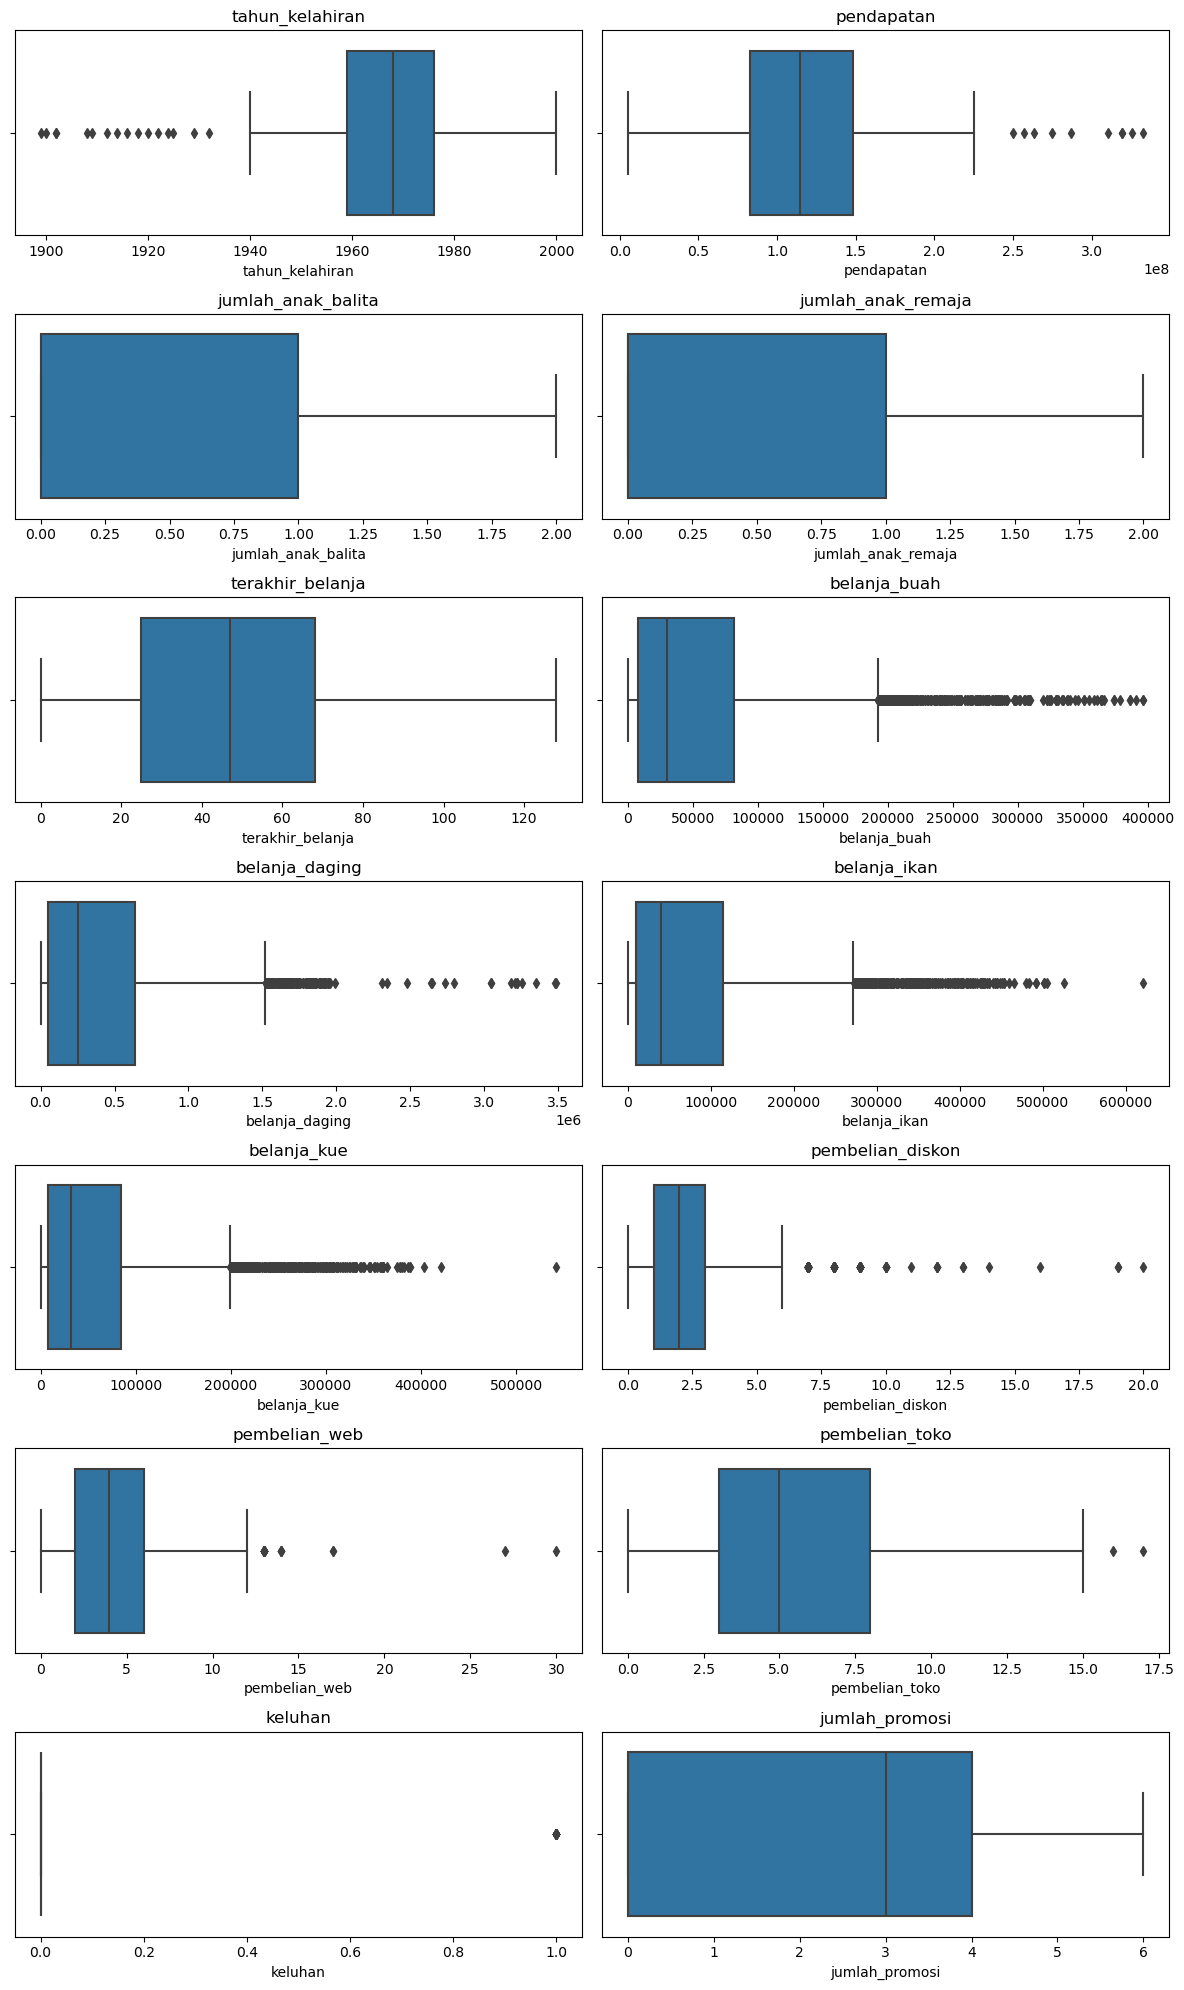

In [1116]:
# Data Training
numFeatures = dataTraining.select_dtypes(include='number').columns

# Tentukan ukuran kanvas subplot
numPlots = len(numFeatures)
numRows = numPlots // 2 + numPlots % 2  # Hitung jumlah baris
fig, axes = plt.subplots(nrows=numRows, ncols=2, figsize=(12, 20), 
                         gridspec_kw={'height_ratios': [1]*numRows})  # Set tinggi setiap baris sama

# Looping melalui kolom numerik
for i, column in enumerate(numFeatures):
    row = i // 2
    col = i % 2
    sns.boxplot(x=dataTraining[column], ax=axes[row, col])
    axes[row, col].set_title(column)

# Menghapus subplot yang tidak digunakan jika jumlah kolom ganjil
if numPlots % 2 != 0:
    fig.delaxes(axes[numRows-1, 1])

plt.tight_layout()
plt.show()

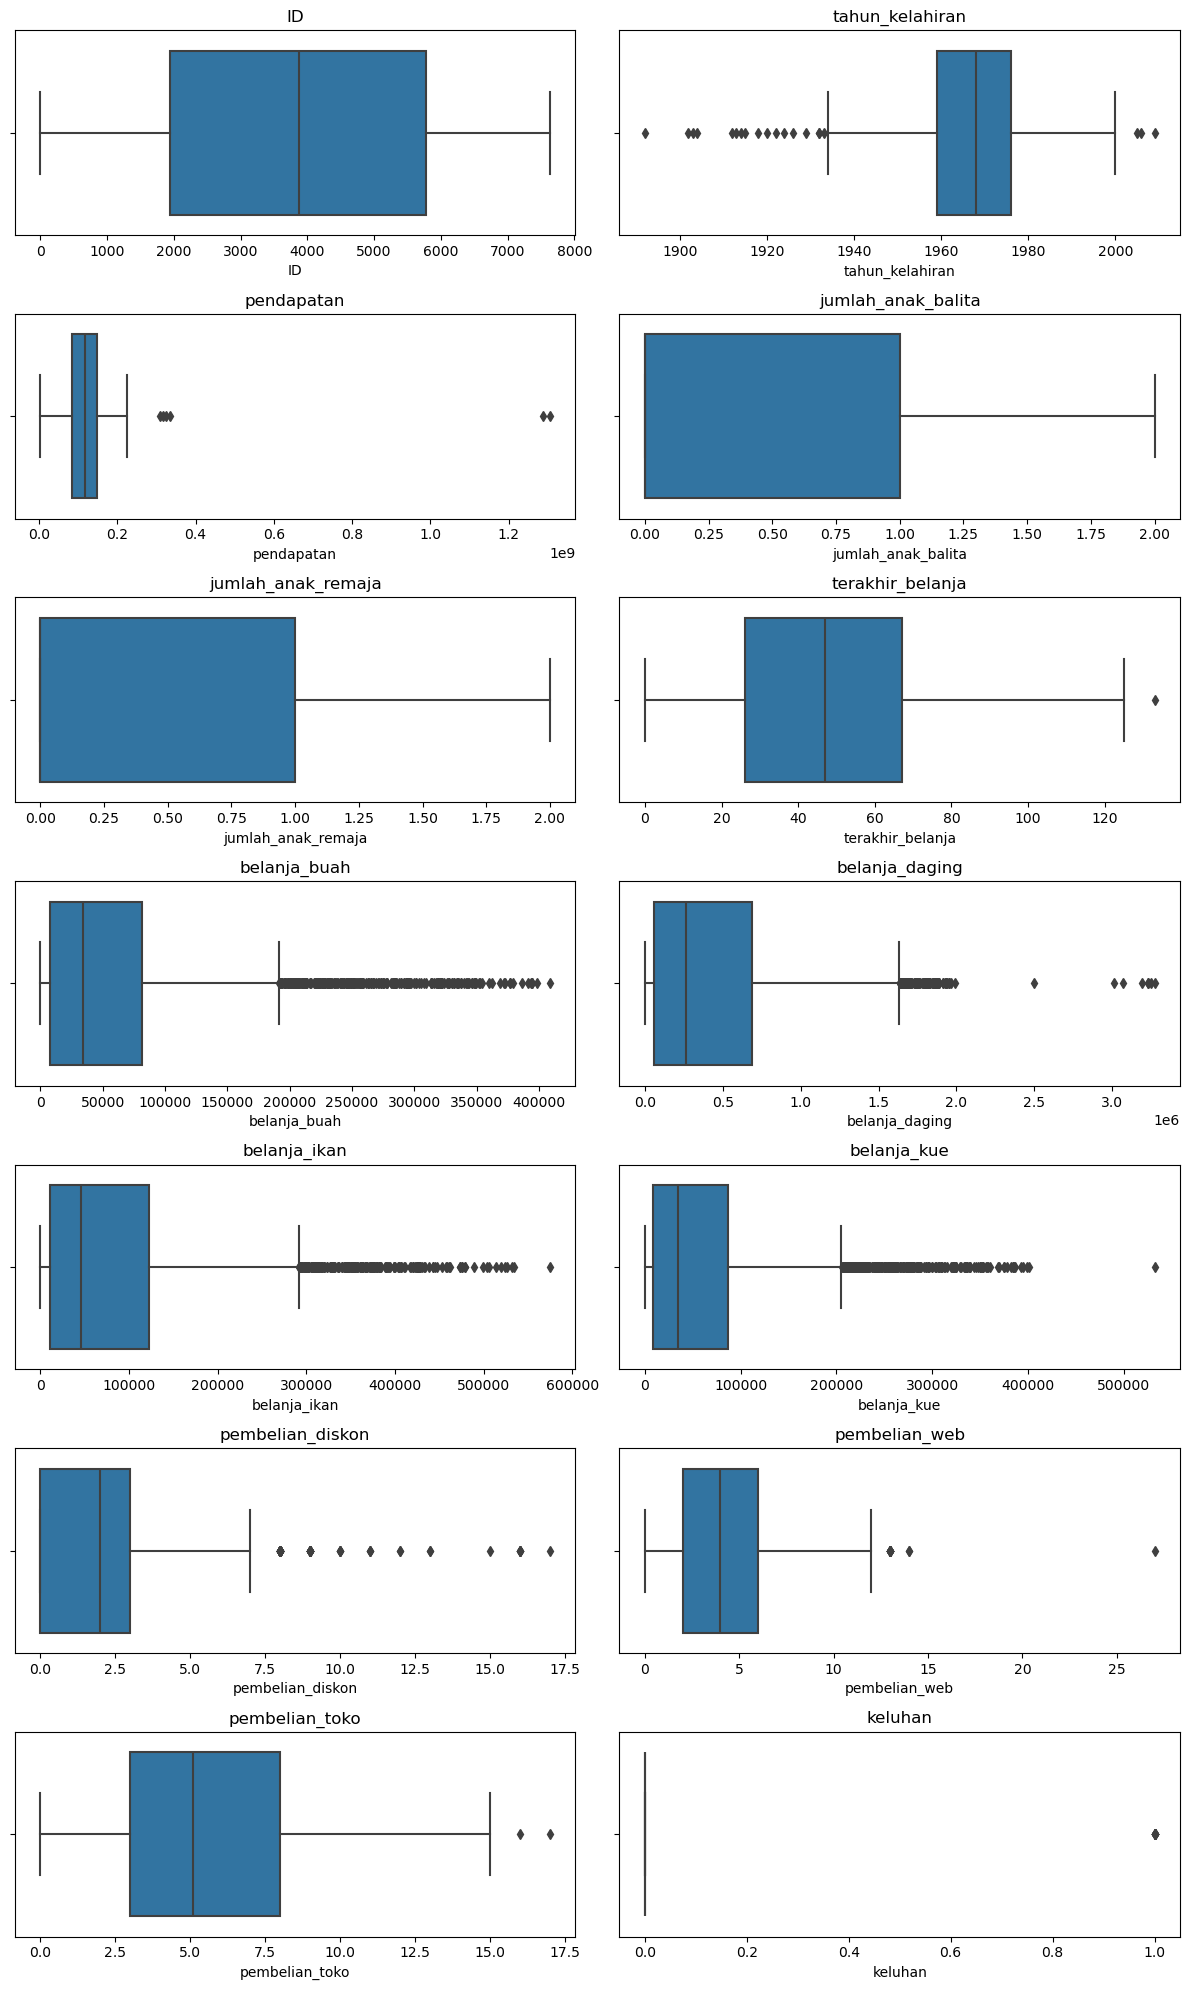

In [1117]:
# Data Testing
numFeatures = dataTesting.select_dtypes(include='number').columns

# Tentukan ukuran kanvas subplot
numPlots = len(numFeatures)
numRows = numPlots // 2 + numPlots % 2  # Hitung jumlah baris
fig, axes = plt.subplots(nrows=numRows, ncols=2, figsize=(12, 20), 
                         gridspec_kw={'height_ratios': [1]*numRows})  # Set tinggi setiap baris sama

# Looping melalui kolom numerik
for i, column in enumerate(numFeatures):
    row = i // 2
    col = i % 2
    sns.boxplot(x=dataTesting[column], ax=axes[row, col])
    axes[row, col].set_title(column)

# Menghapus subplot yang tidak digunakan jika jumlah kolom ganjil
if numPlots % 2 != 0:
    fig.delaxes(axes[numRows-1, 1])

plt.tight_layout()
plt.show()

Dari hasil analisis banyak outliers di atas, terlihat bahwa ada beberapa kolom yang masih terdapat nilai outliers yang perlu ditangani. Namun juga perlu adanya seleksi lagi kolom-kolom yang perlu ditangani dan juga yang tidak. 

Untuk kolom yang tidak perlu yaitu kolom-kolom numerik dengan nilai terbilang sedikit variasi nilainya.

### Hapus Nilai Outliers

In [1118]:
# Data Training

ignoredColumn = ['keluhan', 'jumlah_anak_balita', 'jumlah_anak_remaja', 'tahun_kelahiran']
interpolateColumn = ['belanja_buah', 'belanja_ikan', 'belanja_daging', 'belanja_kue']

# Fungsi untuk menghapus outlier menggunakan pendekatan IQR
def replace_outliers_with_interpolation(df):
    cleaned_data = df.copy()  # Salin dataframe asli untuk dimodifikasi
    
    # Loop melalui setiap kolom numerik
    for column in df.select_dtypes(include='number').columns:
        if column not in ignoredColumn:  # Lewati kolom yang diabaikan
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            if column in interpolateColumn:
                # Interpolasi nilai outliers
                outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
                interpolated_values = (outliers[column] - lower_bound) / (upper_bound - lower_bound) * (Q3 - Q1) + Q1
                cleaned_data.loc[outliers.index, column] = interpolated_values
            cleaned_data[column] = cleaned_data[column].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
    return cleaned_data

# Hapus outlier menggunakan pendekatan IQR untuk setiap kolom (kecuali yang diabaikan)
cleanedTraining = replace_outliers_with_interpolation(dataTraining)

In [1119]:
# Data Testing

ignoredColumn = ['keluhan', 'jumlah_anak_balita', 'jumlah_anak_remaja', 'tahun_kelahiran', 'ID']
interpolateColumn = ['belanja_buah', 'belanja_ikan', 'belanja_daging', 'belanja_kue']

# Fungsi untuk menghapus outlier menggunakan pendekatan IQR
def replace_outliers_with_interpolation(df):
    cleaned_data = df.copy()  # Salin dataframe asli untuk dimodifikasi
    
    # Loop melalui setiap kolom numerik
    for column in df.select_dtypes(include='number').columns:
        if column not in ignoredColumn:  # Lewati kolom yang diabaikan
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            if column in interpolateColumn:
                # Interpolasi nilai outliers
                outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
                interpolated_values = (outliers[column] - lower_bound) / (upper_bound - lower_bound) * (Q3 - Q1) + Q1
                cleaned_data.loc[outliers.index, column] = interpolated_values
            cleaned_data[column] = cleaned_data[column].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
    return cleaned_data

# Hapus outlier menggunakan pendekatan IQR untuk setiap kolom (kecuali yang diabaikan)
cleanedTesting = replace_outliers_with_interpolation(dataTesting)

### Cek Ulang Nilai Outliers

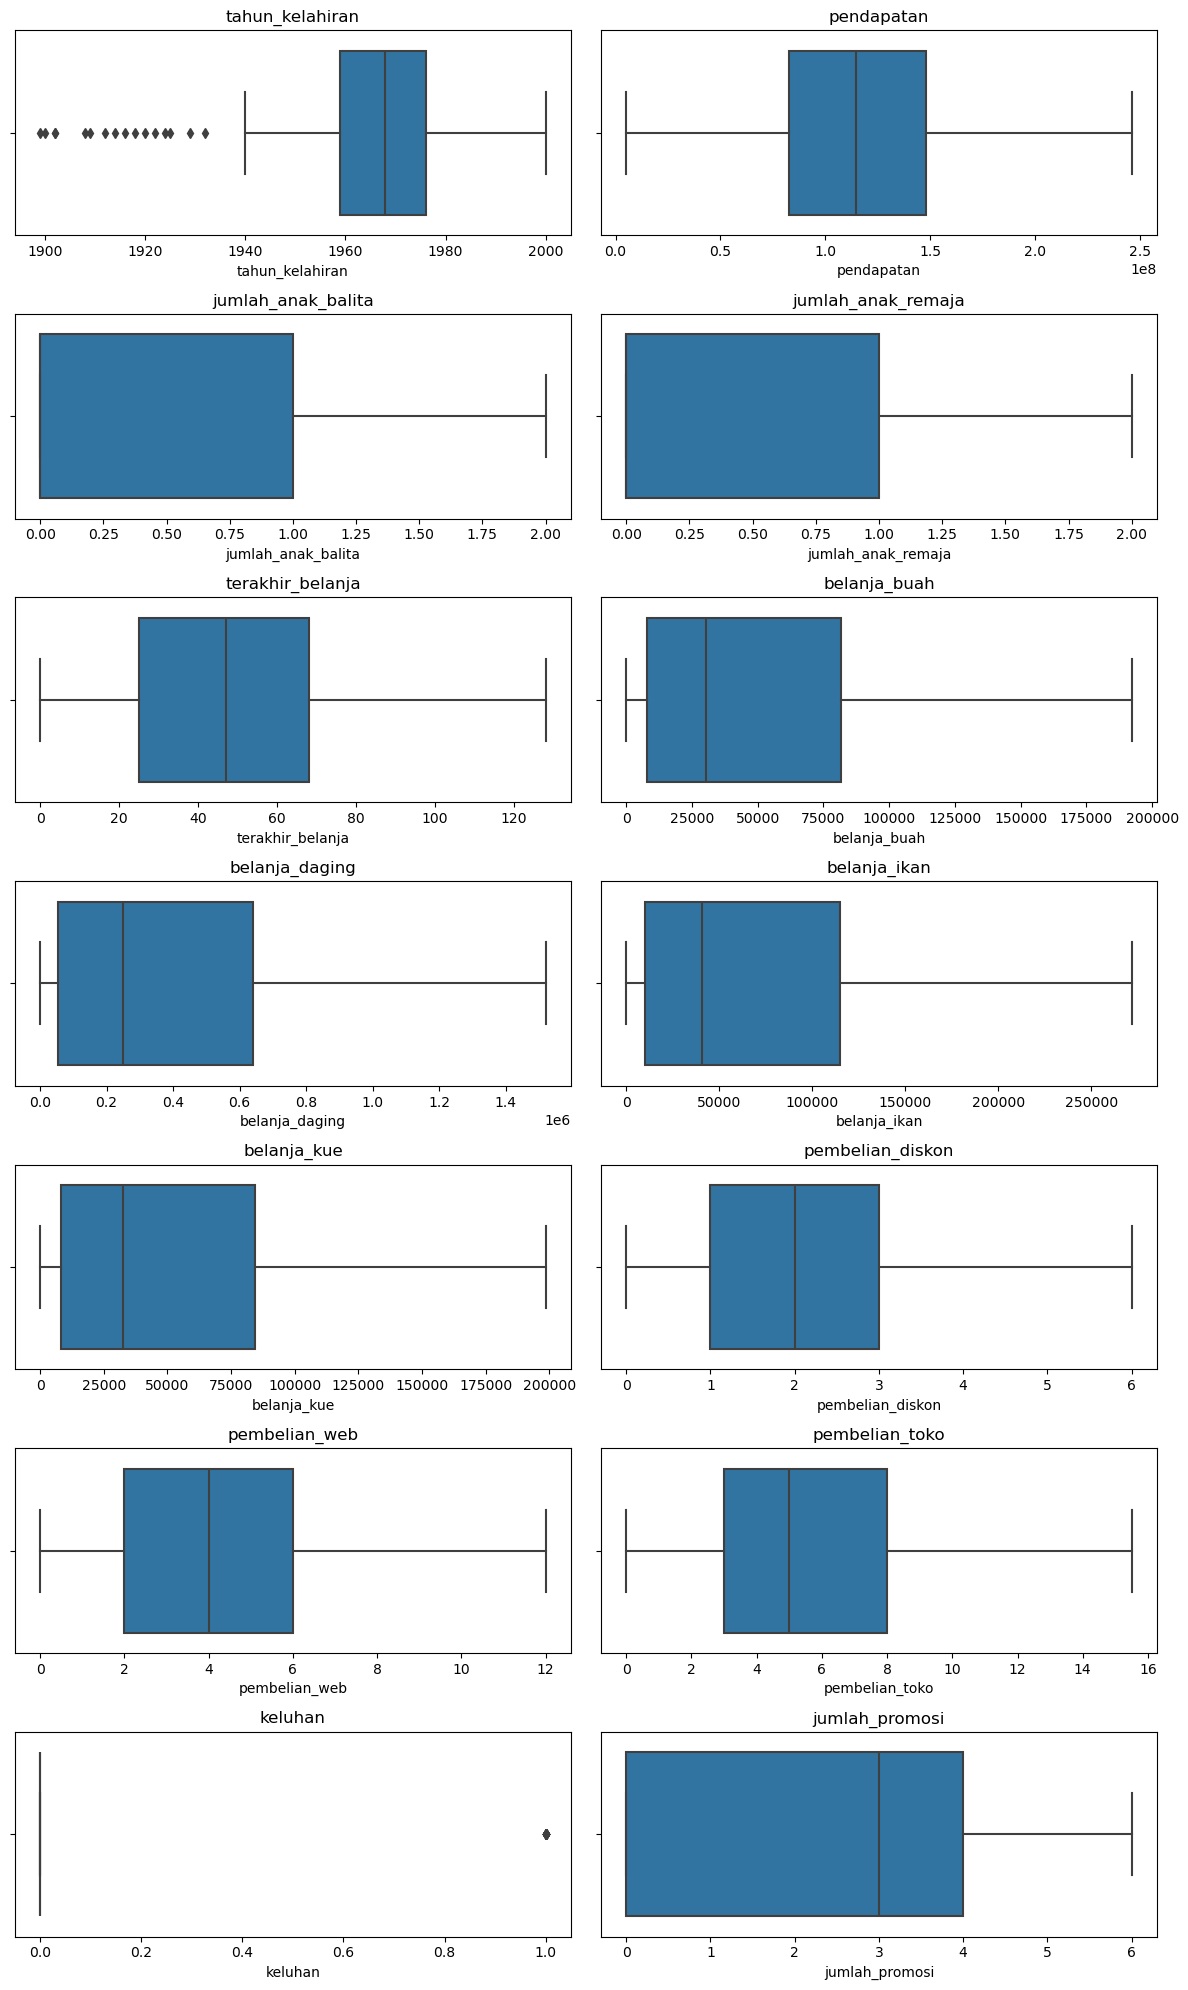

In [1120]:
# Data Training

numFeatures = cleanedTraining.select_dtypes(include='number').columns

# Tentukan ukuran kanvas subplot
numPlots = len(numFeatures)
numRows = numPlots // 2 + numPlots % 2  # Hitung jumlah baris
fig, axes = plt.subplots(nrows=numRows, ncols=2, figsize=(12, 20), 
                         gridspec_kw={'height_ratios': [1]*numRows})  # Set tinggi setiap baris sama

# Looping melalui kolom numerik
for i, column in enumerate(numFeatures):
    row = i // 2
    col = i % 2
    sns.boxplot(x=cleanedTraining[column], ax=axes[row, col])
    axes[row, col].set_title(column)

# Menghapus subplot yang tidak digunakan jika jumlah kolom ganjil
if numPlots % 2 != 0:
    fig.delaxes(axes[numRows-1, 1])

plt.tight_layout()
plt.show()

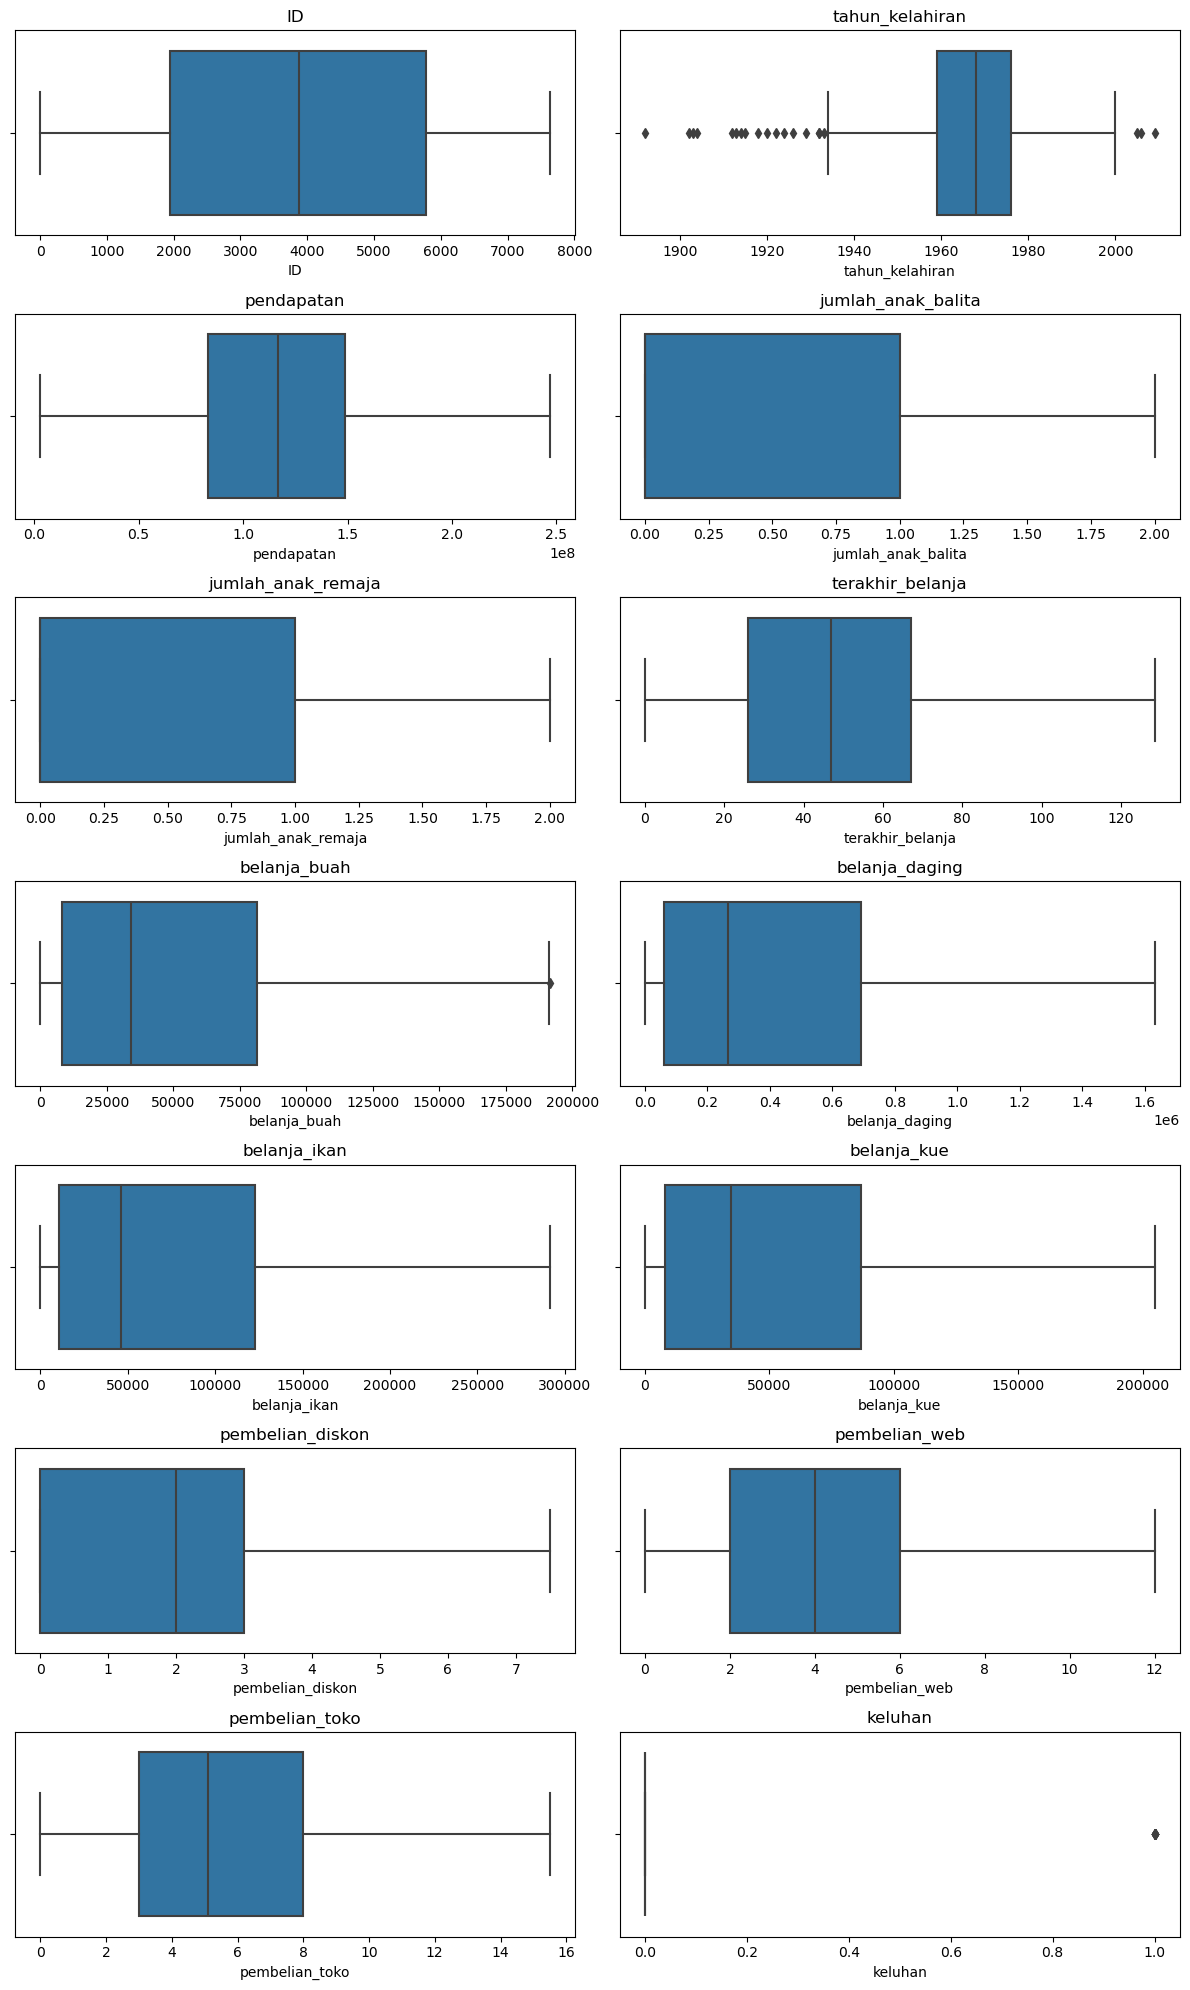

In [1121]:
# Data Testing

numFeatures = cleanedTesting.select_dtypes(include='number').columns

# Tentukan ukuran kanvas subplot
numPlots = len(numFeatures)
numRows = numPlots // 2 + numPlots % 2  # Hitung jumlah baris
fig, axes = plt.subplots(nrows=numRows, ncols=2, figsize=(12, 20), 
                         gridspec_kw={'height_ratios': [1]*numRows})  # Set tinggi setiap baris sama

# Looping melalui kolom numerik
for i, column in enumerate(numFeatures):
    row = i // 2
    col = i % 2
    sns.boxplot(x=cleanedTesting[column], ax=axes[row, col])
    axes[row, col].set_title(column)

# Menghapus subplot yang tidak digunakan jika jumlah kolom ganjil
if numPlots % 2 != 0:
    fig.delaxes(axes[numRows-1, 1])

plt.tight_layout()
plt.show()

Setelah dilakukan proses penghapusan outliers, saat ini sudah tidak ada outliers pada setiap kolom di data training.

## Jawab Pertanyaan Analisis, dan Analisis Invalid Value Lanjut

Pada sesi ini, menjawab pertanyaan analisis dengan berbagai langkah analisis disertai dengan Analisis Invalid Value Lanjut. Untuk proses analisis yang digunakan hanyalah dataset **Training**. Sebab terdapat perbedaan pola dataset.

### Pertanyaan 1

Pada pertanyaan 1, perlu melakukan analisa pada kolom **Tahun Kelahiran** untuk mengetahui usia berapa saja setiap pengguna yang terdata pada dataset.

In [1122]:
# Mengambil nilai tahun sekarang
yearNow = datetime.now().year
# Mengurangi tahun kelahiran dengan tahun sekarang, masukkan dalam kolom baru
# Data Training
cleanedTraining['usia'] = yearNow - cleanedTraining['tahun_kelahiran']
# Data Training
cleanedTesting['usia'] = yearNow - cleanedTesting['tahun_kelahiran']

Setelah mendapatkan angka usia pada setiap pengguna, selanjutnya adalah membuat rentang usia.

In [1123]:
# Membuat batas rentang usia
limitAges = [0, 30, 70, float('inf')]

# Membuat label rentang usia
labelAges = ['Remaja', 'Dewasa', 'Lanjut Usia']

# Membuat kolom baru rentang usia
# Data Training
cleanedTraining['rentang_usia'] = pd.cut(cleanedTraining['usia'], bins=limitAges, labels=labelAges)
# Data Testing
cleanedTesting['rentang_usia'] = pd.cut(cleanedTesting['usia'], bins=limitAges, labels=labelAges)

Setelah dilakukan pembuatan rentang usia, maka perlu dilakukan proses validasi pada nilai-nilai yang ada dan berkaitan dengan pertanyaan 1.

In [1124]:
print('Usia paling muda adalah', cleanedTraining.usia.min())
print('Usia paling tua adalah', cleanedTraining.usia.max())

Usia paling muda adalah 24
Usia paling tua adalah 125


Disini terdeteksi terdapat ketidaktepatan pada data yang sudah ada, yaitu adanya usia yang tidak logis. Maka perlu dilakukan analisis lebih lanjut pada data kolom Tahun **Kelahiran**, **Usia**, dan **Rentang Usia**.

In [1125]:
# Grouping berdasarkan rentang usia
grpAgeRange = cleanedTraining[cleanedTraining['rentang_usia'] == 'Lanjut Usia']

# Mengurutkan setiap nilai unik di kolom usia untuk menentukan batas maksimal usia
print(np.sort(grpAgeRange['usia'].unique()))

# Menampilkan banyak data di atas batas maksimal
print("Banyak data di atas batas maksimal", len(cleanedTraining[cleanedTraining['usia'] > 84]))

[ 71  72  73  74  75  76  77  78  79  80  81  82  83  84  92  95  99 100
 102 104 106 108 110 112 115 116 122 124 125]
Banyak data di atas batas maksimal 16


Dari hasil analisis di atas, dari penentuan batas maksimal usia lansia adalah **84** dengan banyak data di atas batas maksimal (Invalid Value) adalah **16**. Maka dapat dilakukan penghapusan data di atas batas maksimal.

In [1126]:
cleanedTraining = cleanedTraining[cleanedTraining['usia'] <= 84]

Setelah dilakukan pembersihan, dapat disimpulkan rentang usia berdasarkan usia pengguna adalah sebagai berikut:

In [1127]:
grpAges = cleanedTraining.groupby('rentang_usia').agg({
    'usia': ['count', 'min', 'max']
})

for rentang, nilai in grpAges.iterrows():
    print(f"Pada rentang usia {rentang} yaitu usia {nilai['usia']['min']}-{nilai['usia']['max']}, terdapat {nilai['usia']['count']} pengguna.")

Pada rentang usia Remaja yaitu usia 24-30, terdapat 23 pengguna.
Pada rentang usia Dewasa yaitu usia 31-70, terdapat 3367 pengguna.
Pada rentang usia Lanjut Usia yaitu usia 71-84, terdapat 408 pengguna.


C:\Users\legion\AppData\Local\Temp\ipykernel_53936\3430756595.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grpAges = cleanedTraining.groupby('rentang_usia').agg({


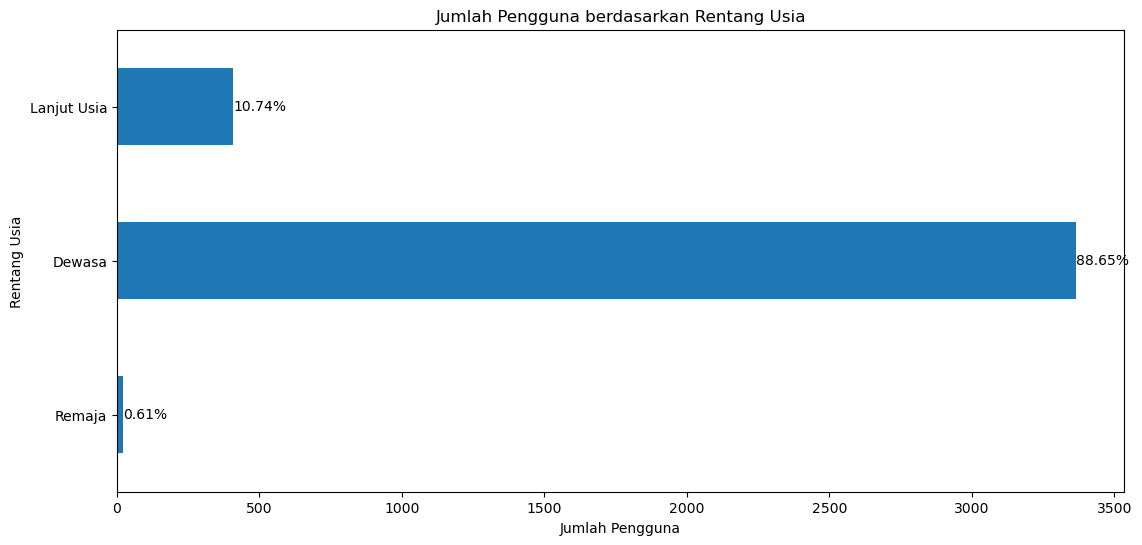

In [1128]:
# Plotting bar chart
plt.figure(figsize=(13, 6))
bars = grpAges['usia', 'count'].plot(kind='barh')
plt.xlabel('Jumlah Pengguna')
plt.ylabel('Rentang Usia')
plt.title('Jumlah Pengguna berdasarkan Rentang Usia')
plt.legend().remove()  # Menghapus legend

# Menambahkan persentase pada setiap bar
for bar in bars.patches:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width() / sum(grpAges["usia", "count"]) * 100:.2f}%',
             va='center')

plt.show()

Dari hasil visualisasi data pada analisis univarian di atas dapat disimpulkan bahwa pengguna terbanyak yang terdata adalah golongan rentang usia **Dewasa**.

### Pertanyaan 2

Pada sesi ini akan menjawab pertanyaan 2, dengan menganalisa nilai-nilai yang ada di kolom **Pendidikan**. Tujuannya yaitu untuk mengetahui banyak porsi presentase setiap jenis pendidikan terakhir.

In [1129]:
# Nilai unique kolom pendidikan
cleanedTraining.pendidikan.unique()

array(['Sarjana', 'Magister', 'SMA', 'SMP', 'Doktor'], dtype=object)

            Jumlah sampel
pendidikan               
Sarjana              2030
Magister              852
SMA                   435
Doktor                390
SMP                    91


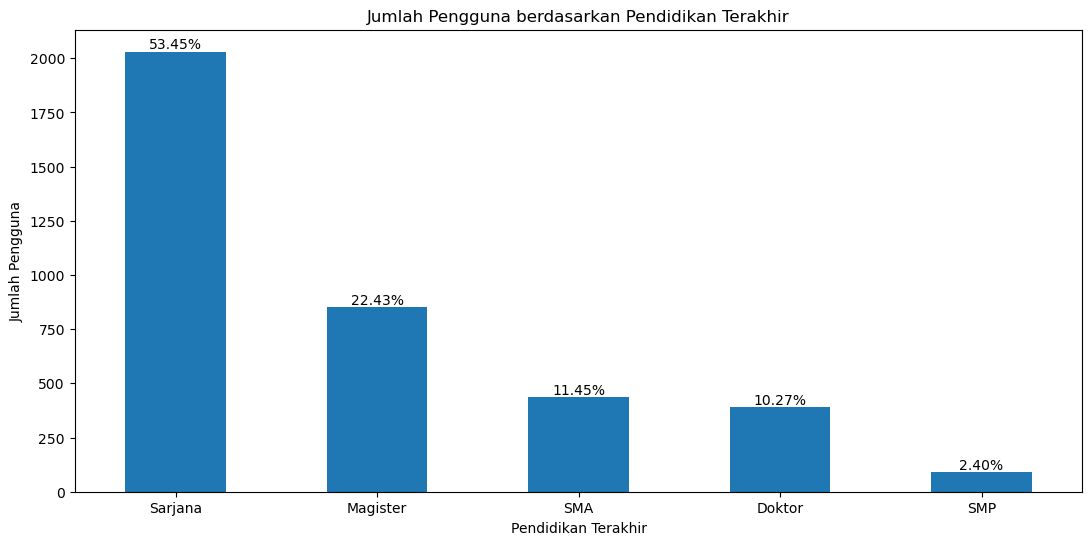

In [1130]:
count = cleanedTraining['pendidikan'].value_counts()
df = pd.DataFrame({
    'Jumlah sampel':count, 
})
print(df)

# Plotting bar chart vertikal
plt.figure(figsize=(13, 6))
bars = count.plot(kind='bar', rot=0)
plt.xlabel('Pendidikan Terakhir')
plt.ylabel('Jumlah Pengguna')
plt.title('Jumlah Pengguna berdasarkan Pendidikan Terakhir')
plt.legend().remove()  # Menghapus legend

# Menambahkan persentase pada setiap bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height() / sum(count) * 100:.2f}%',
             ha='center', va='bottom')

plt.show()

Dari hasil visualisasi data pada analisis univarian di atas dapat disimpulkan bahwa pengguna mayoritas memiliki pendidikan terakhir **Sarjana**.

### Pertanyaan 3

Pada sesi ini akan dilakukan analisis latar belakang pengguna berdasarkan status pernikahan

In [1131]:
# Nilai unique status pernikahan
cleanedTraining.status_pernikahan.unique()

array(['Rencana Menikah', 'Menikah', 'Sendiri', 'Cerai', 'Cerai Mati'],
      dtype=object)

                   Jumlah sampel
status_pernikahan               
Rencana Menikah             1261
Menikah                     1229
Sendiri                     1054
Cerai                        214
Cerai Mati                    40


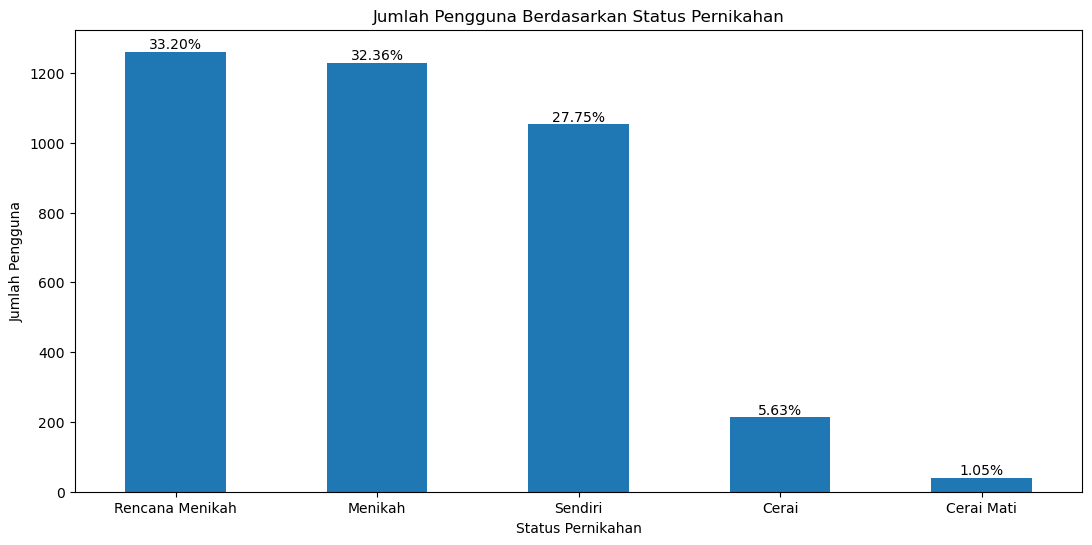

In [1132]:
count = cleanedTraining['status_pernikahan'].value_counts()
df = pd.DataFrame({
    'Jumlah sampel':count, 
})
print(df)

# Plotting bar chart vertikal
plt.figure(figsize=(13, 6))
bars = count.plot(kind='bar', rot=0)
plt.xlabel('Status Pernikahan')
plt.ylabel('Jumlah Pengguna')
plt.title('Jumlah Pengguna Berdasarkan Status Pernikahan')
plt.legend().remove()  # Menghapus legend

# Menambahkan persentase pada setiap bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height() / sum(count) * 100:.2f}%',
             ha='center', va='bottom')

plt.show()

Dari hasil visualisasi data pada analisis univarian di atas dapat disimpulkan bahwa pengguna mayoritas memiliki status pernikahan **Rencana Menikah**, yang berbeda tipis dengan status pernikahan **Menikah**.

### Pertanyaan 4

Pada sesi ini akan dilakukan analisis latar belakang pengguna berdasarkan kepemilikan anak, dengan menganalisis kolom **Jumlah Anak Balita** dan **Jumlah Anak Remaja**

In [1133]:
# Buat Kolom Baru, yaitu memiliki anak
def haveChildFunct(df):
    for index, row in df.iterrows():
        # Kondisi penentuan nilai kepemilikan anak
        if row['jumlah_anak_balita'] > 0 or row['jumlah_anak_remaja'] > 0:
            df.at[index, 'memiliki_anak'] = 'Memiliki'
        else:
            df.at[index, 'memiliki_anak'] = 'Tidak Memiliki'

# Data Training
haveChildFunct(cleanedTraining)

# Data Training
haveChildFunct(cleanedTesting)

Saat ini dataframe utama sudah memiliki kolom kepemilikan anak. Selanjutnya adalah melakukan agregasi data untuk memvalidasi data yang ada.

In [1134]:
# Hitung jumlah anak berdasarkan status pernikahan (validasi)
countWed = cleanedTraining.groupby(['status_pernikahan', 'memiliki_anak'])['memiliki_anak'].count()
countWed

status_pernikahan  memiliki_anak 
Cerai              Memiliki           51
                   Tidak Memiliki    163
Cerai Mati         Memiliki           10
                   Tidak Memiliki     30
Menikah            Memiliki          395
                   Tidak Memiliki    834
Rencana Menikah    Memiliki          281
                   Tidak Memiliki    980
Sendiri            Memiliki          294
                   Tidak Memiliki    760
Name: memiliki_anak, dtype: int64

Pada hasil di atas, nampaknya terdapat kesalahan data yaitu pada kategori **Sendiri** dan **Rencana Menikah** yang tercatat **memiliki anak**. Untuk menghindari mispersepsi, penanganan akan dilakukan pada dataset dengan cara mengubah nilai kepemilikan anak, serta menjalankan proses pengisian kolom **Memiliki Anak** secara ulang.

In [1135]:
# Filter DataFrame untuk status pernikahan "Sendiri"
beforeMarried = cleanedTraining[(cleanedTraining['status_pernikahan'] == 'Sendiri') | (cleanedTraining['status_pernikahan'] == 'Rencana Menikah')]

# Ubah nilai kolom 'jumlah_anak_balita', 'jumlah_anak_remaja', dan 'memiliki_anak' untuk baris-baris tersebut
cleanedTraining.loc[beforeMarried.index, 'jumlah_anak_balita'] = 0
cleanedTraining.loc[beforeMarried.index, 'jumlah_anak_remaja'] = 0
cleanedTraining.loc[beforeMarried.index, 'memiliki_anak'] = 'Tidak Memiliki'


In [1136]:
# Cek ulang Nilai Count
# Hitung jumlah anak berdasarkan status pernikahan (validasi)
sendiriRow = cleanedTraining[(cleanedTraining['status_pernikahan'] == 'Rencana Menikah') & (cleanedTraining['memiliki_anak'] == 'Memiliki')]
sendiriRow.shape[0]

0

Setelah dipastikan sudah tidak ada nilai invalid yang ada, maka selanjutnya dilakukan proses visualisasi data.

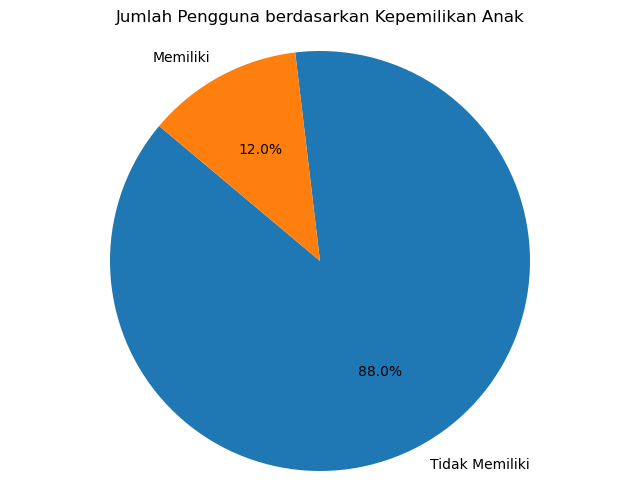

In [1137]:
# Hitung jumlah masing-masing nilai unik dalam kolom 'memiliki_anak'
count = cleanedTraining['memiliki_anak'].value_counts()

# Plotting pie chart
plt.figure(figsize=(8, 6))
labels = count.index
sizes = count.values
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Jumlah Pengguna berdasarkan Kepemilikan Anak')
plt.show()

Terlihat bahwa mayoritas pengguna sudah memiliki anak, Selanjutnya adalah mencari rata-rata banyak anak yang dimiliki oleh pengguna yang memiliki anak.

In [1138]:
# Seleksi data yang memiliki anak
haveChild = cleanedTraining[cleanedTraining['memiliki_anak'] == 'Memiliki']

# Penghitungan rata-rata anak remaja yang dimiliki
teenageChild = haveChild['jumlah_anak_remaja'].mean()

# Penghitungan rata-rata anak balita yang dimiliki
babyChild = haveChild['jumlah_anak_balita'].mean()

# Penghitungan rata-rata anak yang dimiliki
meanChild = (haveChild['jumlah_anak_balita'] + haveChild['jumlah_anak_remaja']).mean()

print('Rata-rata anak remaja yang dimiliki setiap pengguna yang memiliki anak adalah', round(teenageChild), "anak.")
print('Rata-rata anak balita yang dimiliki setiap pengguna yang memiliki anak adalah', round(babyChild), "anak.")
print('Rata-rata anak yang dimiliki setiap pengguna yang memiliki anak adalah', round(meanChild), "anak.")

Rata-rata anak remaja yang dimiliki setiap pengguna yang memiliki anak adalah 1 anak.
Rata-rata anak balita yang dimiliki setiap pengguna yang memiliki anak adalah 1 anak.
Rata-rata anak yang dimiliki setiap pengguna yang memiliki anak adalah 2 anak.


Kesimpulan dari hasil analisis di atas bahwa rata-rata anak yang dimiliki oleh pengguna yang memiliki anak balita maupun remaja adalah **1**. Namun, untuk keseluruhan rata-rata adalah **2**.

### Pertanyaan 5

Pada sesi ini akan dilakukan analisis pendapatan pengguna berdasarkan segmentasi pendapatan, dengan menganalisis kolom **Pendapatan** dan **Segmentasi Pendapatan**

In [1139]:
# Grouping berdasarkan segmentasi pendapatan
grpBySegment = cleanedTraining.groupby('segmentasi_pendapatan')['pendapatan'].mean()

# Membulatkan hingga format puluhan juta
grpBySegment = round(grpBySegment / 1000000, 1)


C:\Users\legion\AppData\Local\Temp\ipykernel_53936\2356568018.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grpBySegment = cleanedTraining.groupby('segmentasi_pendapatan')['pendapatan'].mean()


Setelah mendapatkan nilai rata-rata pada setiap segmentasi, berikut adalah hasil visualisasi data beserta nilai aktualnya:

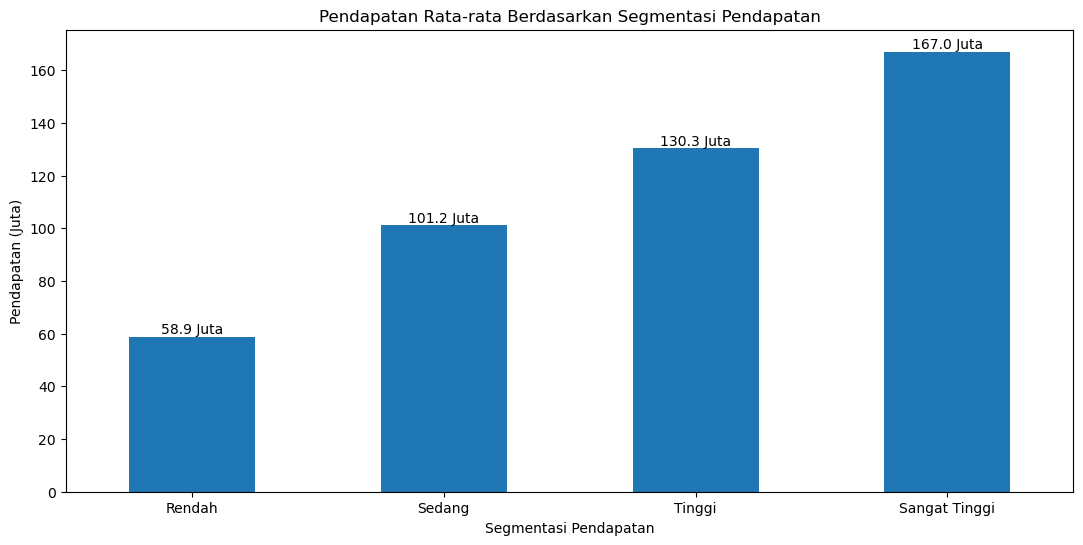

In [1140]:
# Plotting bar chart vertikal
plt.figure(figsize=(13, 6))
bars = grpBySegment.plot(kind='bar', rot=0)
plt.xlabel('Segmentasi Pendapatan')
plt.ylabel('Pendapatan (Juta)')
plt.title('Pendapatan Rata-rata Berdasarkan Segmentasi Pendapatan')
plt.legend().remove()  # Menghapus legend

# Menambahkan nilai aktual pada setiap bar
for bar, nilai in zip(bars.patches, grpBySegment):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{nilai} Juta',
             ha='center', va='bottom')

plt.show()

Kesimpulan dari hasil analisis di atas, dapat disimpulkan bahwa rata-rata pendapatan tertinggi adalah lapisan segmentasi **Sangat Tinggi** dengan nilai **167 Juta**.

### Pertanyaan 6

Pada sesi ini akan dilakukan proses analisis statistik pembelian pengguna berdasarkan pendapatan. Kolom yang dilakukan analisis yaitu Kolom **Segmentasi Pendapatan**, **Pendapatan**, kolom-kolom pembelanjaan, dan **Pembelian Diskon**.

In [1141]:
# Mengambil kolom-kolom yang digunakan
# Data Training
buyingDfTrain = cleanedTraining[['segmentasi_pendapatan','pendapatan', 'belanja_buah', 
                            'belanja_daging', 'belanja_ikan', 'belanja_kue', 
                            'pembelian_diskon']]
# Data Testing
buyingDfTesting = cleanedTesting[['segmentasi_pendapatan','pendapatan', 'belanja_buah', 
                            'belanja_daging', 'belanja_ikan', 'belanja_kue', 
                            'pembelian_diskon']]

In [1142]:
# Mengambil angka kuartil setiap segmen pendapatan
# Grouping berdasarkan segmentasi
# Data Training
grpBySegment = buyingDfTrain.groupby('segmentasi_pendapatan')['pendapatan']
# Hitung angka kuartil
quartiles = grpBySegment.quantile([0.25, 0.5, 1])
# Mengubah menjadi dataframe
quartilesDf = pd.DataFrame(round(quartiles))

# Data Testing
grpBySegmentTest = buyingDfTesting.groupby('segmentasi_pendapatan')['pendapatan']
# Hitung angka kuartil
quartilesTest = grpBySegmentTest.quantile([0.25, 0.5, 1])
# Mengubah menjadi dataframe
quartilesDfTest = pd.DataFrame(round(quartilesTest))

quartilesDf

C:\Users\legion\AppData\Local\Temp\ipykernel_53936\2925207996.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grpBySegment = buyingDfTrain.groupby('segmentasi_pendapatan')['pendapatan']
C:\Users\legion\AppData\Local\Temp\ipykernel_53936\2925207996.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grpBySegmentTest = buyingDfTesting.groupby('segmentasi_pendapatan')['pendapatan']


pendapatan
segmentasi_pendapatan                  
Rendah                0.25   46033110.0
                      0.50   62093094.0
                      1.00   82608533.0
Sedang                0.25   93975939.0
                      0.50  101894854.0
                      1.00  114577997.0
Tinggi                0.25  121085968.0
                      0.50  131459496.0
                      1.00  147953453.0
Sangat Tinggi         0.25  155787521.0
                      0.50  165170000.0
                      1.00  245940934.0

Setelah mengetahui nilai di setiap kuartil segmentasi, maka selanjutnya membuat label untuk membuat sub segmentasi pada setiap kuartil yang ada. Hal ini bertujuan untuk mengetahui kebiasaan pengguna dalam berbelanja berdasarkan rentang pendapatannya.

In [1143]:
# Membuat sub-segmentasi berdasarkan kuartil per segmentasi pendapatan
# Buat dictionary kuartil
# Data Training
quartilesDict = {
    'Rendah': {'25%': quartilesDf.loc['Rendah', 0.25][0], '50%': quartilesDf.loc['Rendah', 0.50][0], '100%': quartilesDf.loc['Rendah', 1.0][0]},
    'Sedang': {'25%': quartilesDf.loc['Sedang', 0.25][0], '50%': quartilesDf.loc['Sedang', 0.50][0], '100%': quartilesDf.loc['Sedang', 1.0][0]},
    'Tinggi': {'25%': quartilesDf.loc['Tinggi', 0.25][0], '50%': quartilesDf.loc['Tinggi', 0.50][0], '100%': quartilesDf.loc['Tinggi', 1.0][0]},
    'Sangat Tinggi': {'25%': quartilesDf.loc['Sangat Tinggi', 0.25][0], '50%': quartilesDf.loc['Sangat Tinggi', 0.50][0], 
                      '100%': quartilesDf.loc['Sangat Tinggi', 1.0][0]}
}

# Data Testing
quartilesDictTest = {
    'Rendah': {'25%': quartilesDfTest.loc['Rendah', 0.25][0], '50%': quartilesDfTest.loc['Rendah', 0.50][0], '100%': quartilesDfTest.loc['Rendah', 1.0][0]},
    'Sedang': {'25%': quartilesDfTest.loc['Sedang', 0.25][0], '50%': quartilesDfTest.loc['Sedang', 0.50][0], '100%': quartilesDfTest.loc['Sedang', 1.0][0]},
    'Tinggi': {'25%': quartilesDfTest.loc['Tinggi', 0.25][0], '50%': quartilesDfTest.loc['Tinggi', 0.50][0], '100%': quartilesDfTest.loc['Tinggi', 1.0][0]},
    'Sangat Tinggi': {'25%': quartilesDfTest.loc['Sangat Tinggi', 0.25][0], '50%': quartilesDfTest.loc['Sangat Tinggi', 0.50][0], 
                      '100%': quartilesDfTest.loc['Sangat Tinggi', 1.0][0]}
}
# Buat fungsi transformasi sub-segmentasi
def subSegment(row, dictionary):
    if row['pendapatan'] <= dictionary[row['segmentasi_pendapatan']]['25%']:
        return 'Bawah'
    elif row['pendapatan'] > dictionary[row['segmentasi_pendapatan']]['25%'] and row['pendapatan'] <= dictionary[row['segmentasi_pendapatan']]['50%']:
        return 'Menengah'
    elif row['pendapatan'] > dictionary[row['segmentasi_pendapatan']]['50%'] and row['pendapatan'] <= dictionary[row['segmentasi_pendapatan']]['100%']:
        return 'Atas'
    else :
        return 'Menengah'

C:\Users\legion\AppData\Local\Temp\ipykernel_53936\248751668.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Rendah': {'25%': quartilesDf.loc['Rendah', 0.25][0], '50%': quartilesDf.loc['Rendah', 0.50][0], '100%': quartilesDf.loc['Rendah', 1.0][0]},
C:\Users\legion\AppData\Local\Temp\ipykernel_53936\248751668.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Sedang': {'25%': quartilesDf.loc['Sedang', 0.25][0], '50%': quartilesDf.loc['Sedang', 0.50][0], '100%': quartilesDf.loc['Sedang', 1.0][0]},
C:\Users\legion\AppData\Local\Temp\ipykernel_53936\248751668.py:7: FutureWarning: Series.__getitem__ treating keys a

In [1144]:
# Aplikasikan fungsi ke dataframe
# Data Training
buyingDfTrain['sub_segmentasi'] = buyingDfTrain.apply(lambda row: subSegment(row, quartilesDict), axis=1)
# Data Testing
buyingDfTesting['sub_segmentasi'] = buyingDfTesting.apply(lambda row: subSegment(row, quartilesDictTest), axis=1)

C:\Users\legion\AppData\Local\Temp\ipykernel_53936\2415938121.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buyingDfTrain['sub_segmentasi'] = buyingDfTrain.apply(lambda row: subSegment(row, quartilesDict), axis=1)
C:\Users\legion\AppData\Local\Temp\ipykernel_53936\2415938121.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buyingDfTesting['sub_segmentasi'] = buyingDfTesting.apply(lambda row: subSegment(row, quartilesDictTest), axis=1)


Setelah membuat sub segmentasi, maka selanjutnya adalah melihat hubungan sub segmentasi dengan belanja yang dilakukan.

In [1145]:
# Membuat list kolom belanja
kolomBelanja = ['belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue']

# Membuat dictionary untuk menyimpan nilai mean dan std
nilai_statistik = {}

# Loop untuk setiap segmentasi pendapatan
for segmen in buyingDfTrain['segmentasi_pendapatan'].unique():
    # Loop untuk setiap sub-segmentasi
    for subsegmen in buyingDfTrain['sub_segmentasi'].unique():
        # Membuat kunci untuk dictionary
        kunci = f"{segmen}-{subsegmen}"
        
        # Membuat kondisi untuk filtering data
        kondisi = (buyingDfTrain['segmentasi_pendapatan'] == segmen) & (buyingDfTrain['sub_segmentasi'] == subsegmen)
        
        # Membuat dictionary untuk menyimpan nilai mean dan std dari setiap kolom belanja
        nilai_statistik[kunci] = {}
        for kolom in kolomBelanja:
            # Menghitung mean dan std
            mean = buyingDfTrain[kondisi][kolom].mean()
            std = buyingDfTrain[kondisi][kolom].std()
            # Menyimpan nilai mean dan std ke dalam dictionary
            nilai_statistik[kunci][f"mean_{kolom}"] = mean
            nilai_statistik[kunci][f"std_{kolom}"] = std


In [1146]:
# Membuat list segmentasi pendapatan dan sub-segmentasi
segmentasi_pendapatan = ['Rendah', 'Sedang', 'Tinggi', 'Sangat Tinggi']
sub_segmentasi = ['Bawah', 'Menengah', 'Atas']

# Buat Fungsi Plot 
def plotStats(data, colBuying, incomeSegment, subSegment, stats):
    # Mengatur lebar bar
    bar_width = 0.2

    # Membuat posisi untuk setiap segmentasi pendapatan dan sub-segmentasi
    index = np.arange(len(incomeSegment))
    index_sub = [index - bar_width, index, index + bar_width]

    # Membuat bar chart
    plt.figure(figsize=(10, 6))

    # Loop untuk setiap sub-segmentasi
    for i, subsegmen in enumerate(subSegment):
        # Membuat bar untuk setiap segmentasi pendapatan
        plt.bar(index_sub[i], [data[f'{pendapatan}-{subsegmen}'][f'{stats}_{colBuying}'] for pendapatan in incomeSegment], 
                bar_width, label=subsegmen)

    # Mengatur label pada sumbu x
    plt.xticks(index, incomeSegment)

    # Mengatur label pada sumbu y
    plt.ylabel(stats)

    if stats == 'mean':
        statsTitle = 'Rata-Rata'
    else:
        statsTitle = 'Standar Deviasi'
    # Menambahkan judul
    plt.title(f'{statsTitle} {colBuying} Berdasarkan Segmentasi Pendapatan dan Sub-Segmentasi')

    # Menambahkan legenda
    plt.legend()

    # Menampilkan plot
    plt.show()

Setelah mendapatkan setiap nilai statistik yang dibutuhkan yaitu standar deviasi dan rata-rata, untuk mengetahui pola datanya perlu dilakukan visualisasi data. Berikut adalah visualisasinya:

1. Kolom Belanja Buah

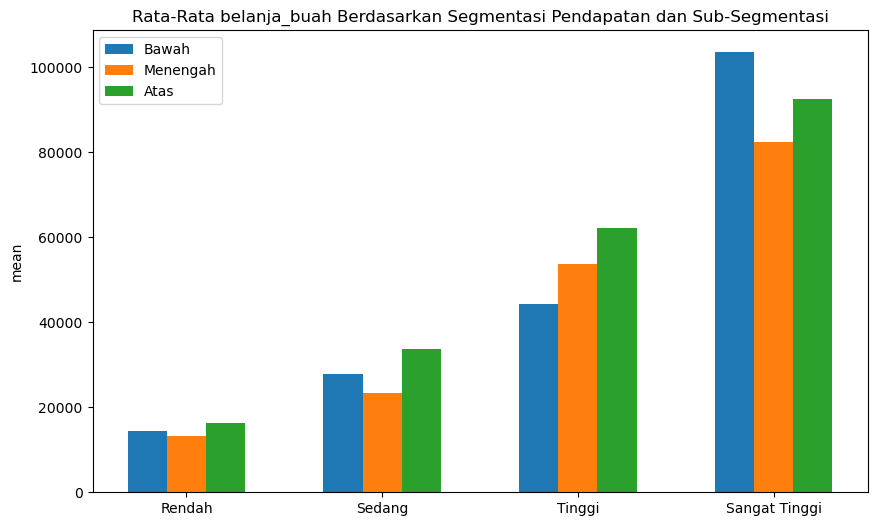

In [1147]:
# Kolom Belanja Buah (Mean)
jenis_kolom_belanja = 'belanja_buah'
jenis_statistik = 'mean'
# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, segmentasi_pendapatan, sub_segmentasi, jenis_statistik)

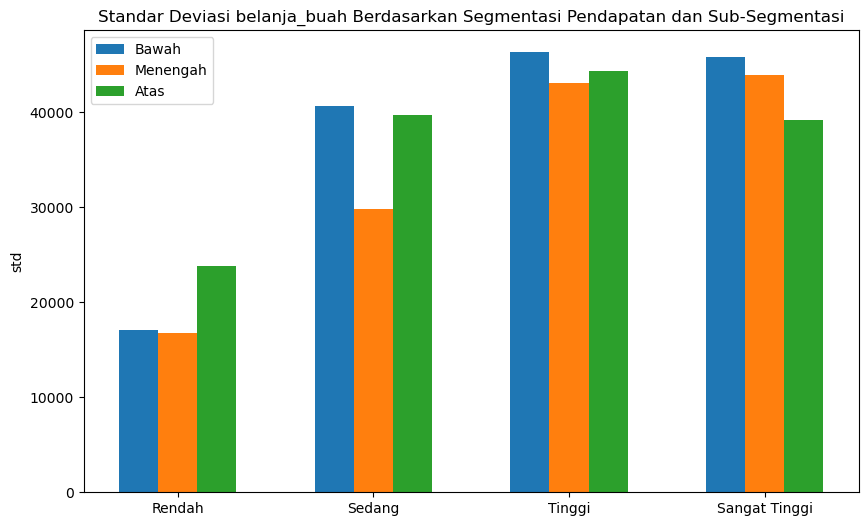

In [1148]:
# Kolom Belanja Buah (Std)
jenis_kolom_belanja = 'belanja_buah'
jenis_statistik = 'std'
# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, segmentasi_pendapatan, sub_segmentasi, jenis_statistik)


Dari hasil visualisasi data di atas, dapat ditarik kesimpulan bahwa pembelian paling dominan dilakukan pada segmentasi dan sub-segmentasi:
- Segmentasi **Sangat Tinggi** sub-segmentasi **Bawah**.
- Segmentasi **Tinggi** sub-segmentasi **Atas**
- Segmentasi **Tinggi** sub-segmentasi **Bawah**
- Segmentasi **Sangat Tinggi** sub-segmentasi **Atas**
- Segmentasi **Sangat Tinggi** sub-segmentasi **Menengah**

2. Kolom Belanja Daging

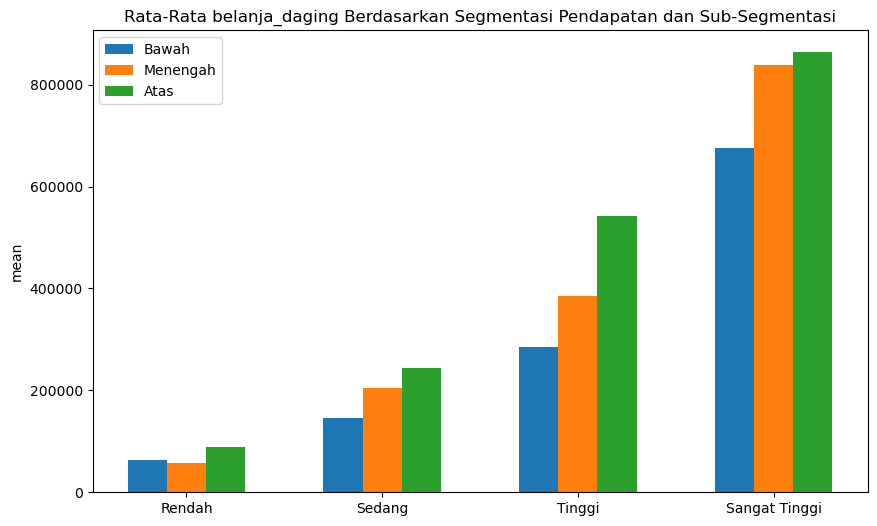

In [1149]:
# Kolom Belanja Daging (Mean)
jenis_kolom_belanja = 'belanja_daging'
jenis_statistik = 'mean'
# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, segmentasi_pendapatan, sub_segmentasi, jenis_statistik)


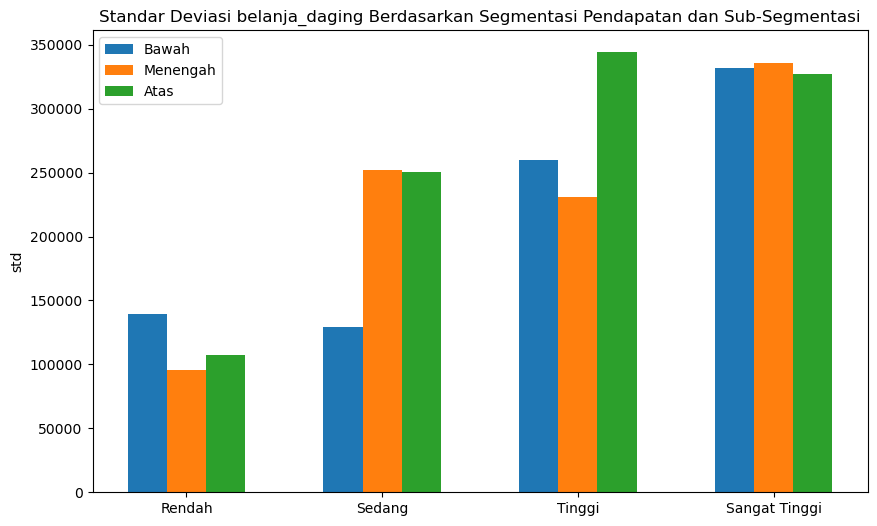

In [1150]:
# Kolom Belanja Daging (Std)
jenis_kolom_belanja = 'belanja_daging'
jenis_statistik = 'std'
# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, segmentasi_pendapatan, sub_segmentasi, jenis_statistik)


Dari hasil visualisasi data di atas, dapat ditarik kesimpulan bahwa pembelian paling dominan dilakukan pada segmentasi dan sub-segmentasi:
- Segmentasi **Sangat Tinggi** sub-segmentasi **Menengah**.
- Segmentasi **Sangat Tinggi** sub-segmentasi **Atas**
- Segmentasi **Tinggi** sub-segmentasi **Atas**
- Segmentasi **Sangat Tinggi** sub-segmentasi **Bawah**
- Segmentasi **Tinggi** sub-segmentasi **Bawah**

3. Kolom Belanja Ikan

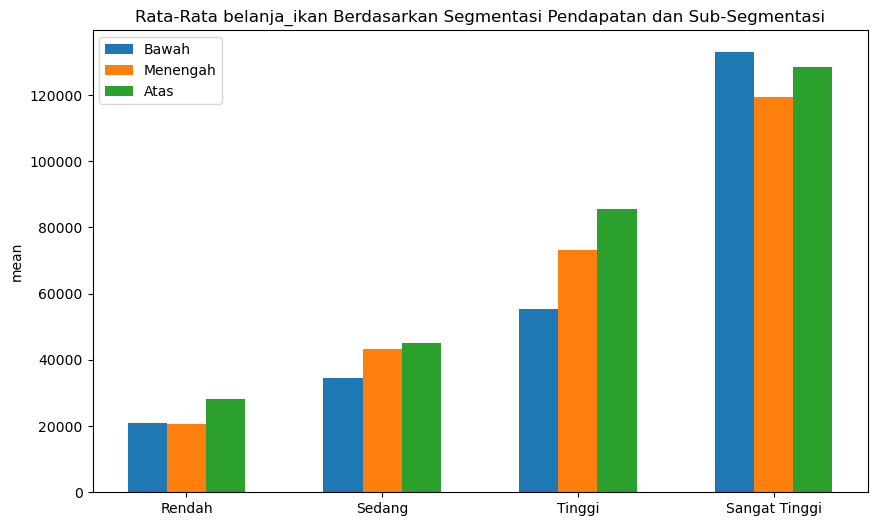

In [1151]:
# Kolom Belanja Ikan (Mean)
jenis_kolom_belanja = 'belanja_ikan'
jenis_statistik = 'mean'
# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, segmentasi_pendapatan, sub_segmentasi, jenis_statistik)


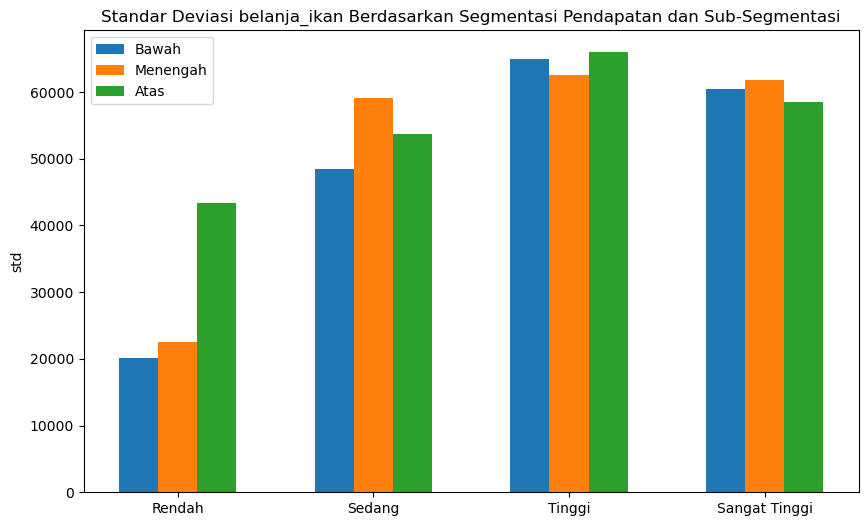

In [1152]:
# Kolom Belanja Ikan (Std)
jenis_kolom_belanja = 'belanja_ikan'
jenis_statistik = 'std'
# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, segmentasi_pendapatan, sub_segmentasi, jenis_statistik)


Dari hasil visualisasi data di atas, dapat ditarik kesimpulan bahwa pembelian paling dominan dilakukan pada segmentasi dan sub-segmentasi:
- Segmentasi **Sangat Tinggi** sub-segmentasi **Bawah**.
- Segmentasi **Sangat Tinggi** sub-segmentasi **Atas**
- Segmentasi **Tinggi** sub-segmentasi **Atas**
- Segmentasi **Tinggi** sub-segmentasi **Bawah**
- Segmentasi **Sangat Tinggi** sub-segmentasi **Menengah**

4. Kolom Belanja Kue

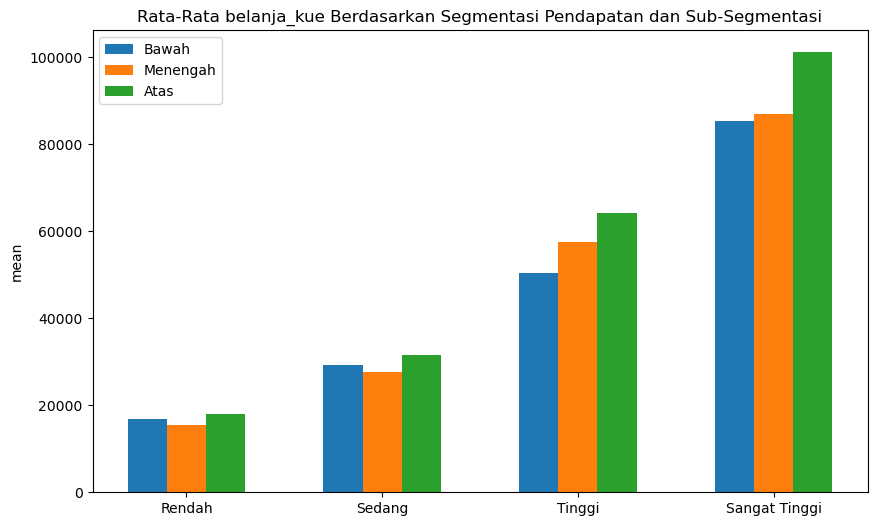

In [1153]:
# Kolom Belanja Kue (Mean)
jenis_kolom_belanja = 'belanja_kue'
jenis_statistik = 'mean'
# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, segmentasi_pendapatan, sub_segmentasi, jenis_statistik)


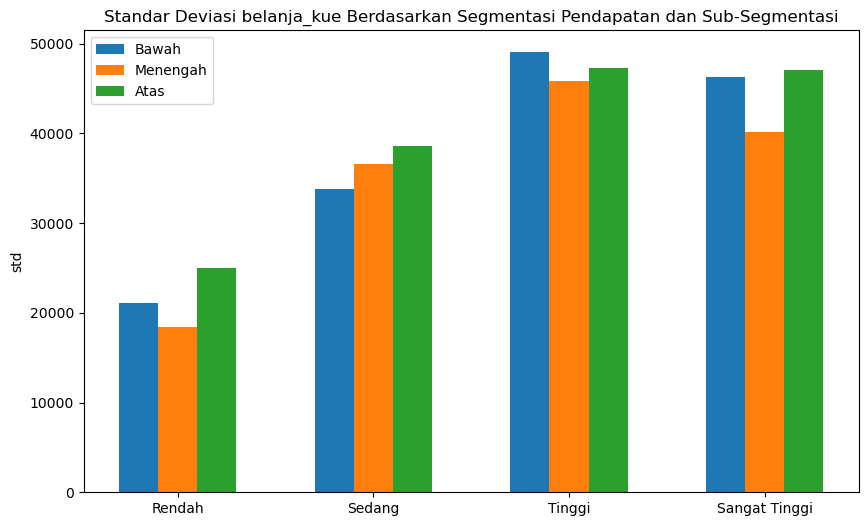

In [1154]:
# Kolom Belanja Kue (Std)
jenis_kolom_belanja = 'belanja_kue'
jenis_statistik = 'std'
# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, segmentasi_pendapatan, sub_segmentasi, jenis_statistik)


Dari hasil visualisasi data di atas, dapat ditarik kesimpulan bahwa pembelian paling dominan dilakukan pada segmentasi dan sub-segmentasi:
- Segmentasi **Sangat Tinggi** sub-segmentasi **Atas**
- Segmentasi **Sangat Tinggi** sub-segmentasi **Bawah**.
- Segmentasi **Sangat Tinggi** sub-segmentasi **Menengah**
- Segmentasi **Tinggi** sub-segmentasi **Atas**
- Segmentasi **Tinggi** sub-segmentasi **Menengah**

Dari analisis di atas dapat ditarik kesimpulan bahwa:

- Rata-rata pengeluaran pengguna untuk berbelanja relatif terhadap pendapatan mereka, ditandai juga dengan standar deviasi yang tidak terlalu jauh. Maka variasi data yang ada tidak begitu menyebar. 
- Rata-rata pengeluaran terbanyak terdapat pada **sub-segmentasi Atas** disusul **sub-segmentasi Rendah** pada **segmentasi pendapatan Sangat Tinggi**. Dengan range pendapatan **165 - 245 Juta** dan **148 - 155 Juta**.
- Terdapat segmentasi-segmentasi pendapatan yang memiliki potensi untuk berbelanja, dilihat dari standar deviasi yang menjanjikan. Berdasarkan urutan tertinggi yaitu:
  1. Segmentasi pendapatan **Tinggi** dengan sub-segmentasi **Atas**. Pada range pendapatan **131 - 147 Juta**.
  2. Segmentasi pendapatan **Tinggi** dengan sub-segmentasi **Bawah**. Pada range pendapatan **114 - 121 Juta**.
  3. Setiap sub-segmentasi di segmentasi pendapatan **Sedang**.
  
  Pada golongan-golongan ini, perlu untuk dilakukan promosi lebih agar mendorong pengguna untuk melakukan perbelanjaan.

- Pada segmentasi pendapatan **Rendah**, pengeluaran untuk belanja paling rendah. 

Selanjutnya adalah menganalisa pembelian dengan parameter diskon, untuk mengetahui bagaimana kebiasaan pengguna dalam berbelanja. Apakah ketika sedang diskon atau tidak, serta mengetahui segmentasi mana saja yang dominan berbelanja ketika sedang ada diskon.

In [1155]:
# Mengambil kolom yang relevan untuk dataframe baru
buyOnDiscDf = buyingDfTrain[['segmentasi_pendapatan', 'sub_segmentasi', 'pembelian_diskon']]
buyOnDiscDf.head()

,segmentasi_pendapatan,sub_segmentasi,pembelian_diskon
0,Sedang,Atas,2.0
1,Sedang,Bawah,6.0
2,Tinggi,Menengah,1.0
3,Sangat Tinggi,Atas,0.0
4,Tinggi,Bawah,6.0


In [1156]:
nilaiDiskon = {}
kolomDiskon = 'pembelian_diskon'
# Loop untuk setiap segmentasi pendapatan
for segmen in buyOnDiscDf['segmentasi_pendapatan'].unique():
    # Loop untuk setiap sub-segmentasi
    for subsegmen in buyOnDiscDf['sub_segmentasi'].unique():
        # Membuat kunci untuk dictionary
        kunci = f"{segmen}-{subsegmen}"
        
        # Membuat kondisi untuk filtering data
        kondisi = (buyOnDiscDf['segmentasi_pendapatan'] == segmen) & (buyOnDiscDf['sub_segmentasi'] == subsegmen)
        
        # Membuat dictionary untuk menyimpan nilai mean dan std dari setiap kolom belanja
        nilaiDiskon[kunci] = {}

        # Menghitung mean dan std
        mean = buyOnDiscDf[kondisi][kolomDiskon].mean()
        std = buyOnDiscDf[kondisi][kolomDiskon].std()
        # Menyimpan nilai mean dan std ke dalam dictionary
        nilaiDiskon[kunci][f"mean_{kolomDiskon}"] = mean
        nilaiDiskon[kunci][f"std_{kolomDiskon}"] = std

Setelah mengambil nilai statistik (mean dan std) pada kolom **Pembelian Diskon** berdasarkan segmentasi dan sub-segmentasi pendapatan, selanjutnya melakukan visualisasi data.

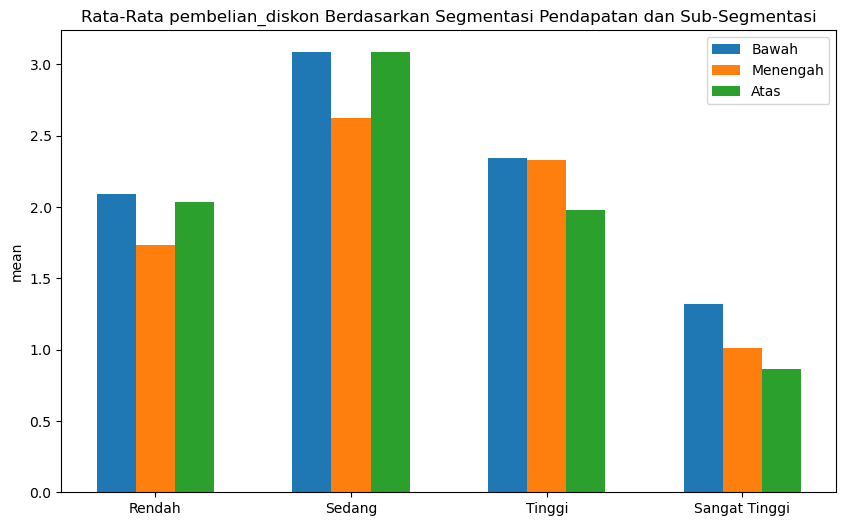

In [1157]:
jenis_kolom_belanja = 'pembelian_diskon'
jenis_statistik = 'mean'
# Plot
plotStats(nilaiDiskon, jenis_kolom_belanja, segmentasi_pendapatan, sub_segmentasi, jenis_statistik)

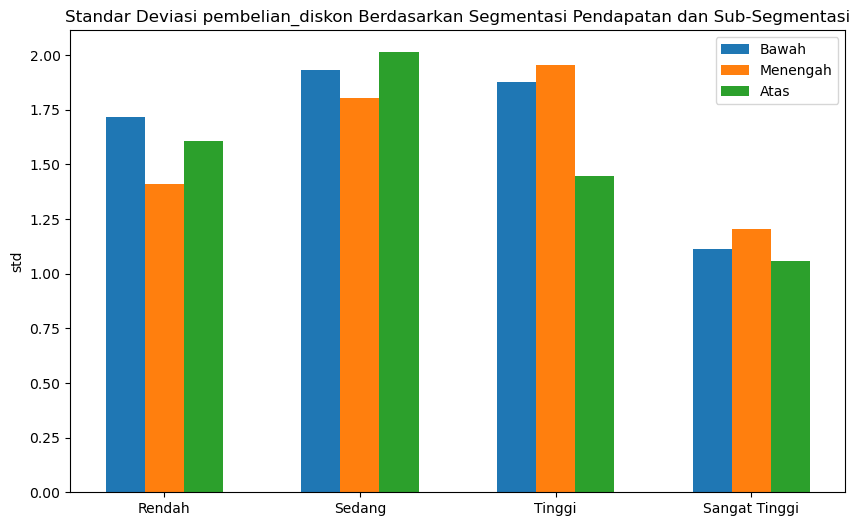

In [1158]:
jenis_kolom_belanja = 'pembelian_diskon'
jenis_statistik = 'std'
# Plot
plotStats(nilaiDiskon, jenis_kolom_belanja, segmentasi_pendapatan, sub_segmentasi, jenis_statistik)

Dari hasil analisa pembelian berdasarkan diskon di atas, dapat disimpulkan bahwa:

- Rata-rata pembelian ketika diskon terbanyak terdapat pada segmentasi pendapatan **Sedang** dengan sub-segmentasi **Bawah** dan **Atas** dengan range pendapatan **82 - 93 Juta** dan **101 - 114 Juta**.

Terdapat beberapa segmentasi dan sub-segmentasi yang berpotensi berbelanja ketika diskon berurutan yaitu:

- Segmentasi pendapatan **Tinggi** dengan sub-segmentasi **Menengah** dan **Bawah**, dengan range pendapatan **122 - 131 Juta** dan **114 - 121 Juta**.
- Segmentasi pendapatan **Rendah** dengan sub-segmentasi **Bawah** dan **Atas**, dengan range pendapatan **5 - 46 Juta** dan **62 - 82 Juta**.

Maka langkah selanjutnya yaitu memberikan promosi diskon dengan frekuensi dari yang tertinggi ke terendah berdasarkan urutan hasil analisis di atas. Yaitu dimulai dari rata-rata tertinggi, dilanjutkan dengan pengguna berpotensi. Serta jalur promosi yang paling diunggulkan, apakah secara luring atau daring.

### Pertanyaan 7

Pada sesi ini akan dilakukan analisis **keluhan pengguna** ketika berbelanja dengan cara **daring (Pembelian Web)** maupun **luring (Pembelian Toko)**. Maka kolom yang digunakan adalah kolom **Segmentasi Pendapatan**, **Sub Segmentasi**, **Pembelian Web**, **Pembelian Toko**, dan **Keluhan**. 

In [1159]:
# Menggabungkan data buying dengan data cleaned training
# Data Training
cleanedTraining['sub_segmentasi'] = buyingDfTrain['sub_segmentasi']
# Data Testing
cleanedTesting['sub_segmentasi'] = buyingDfTesting['sub_segmentasi']

# Mengambil kolom yang diperlukan
worriedBuyDf = cleanedTraining[['segmentasi_pendapatan', 'sub_segmentasi', 'pembelian_web', 'pembelian_toko', 'keluhan']]
worriedBuyDf.head()

,segmentasi_pendapatan,sub_segmentasi,pembelian_web,pembelian_toko,keluhan
0,Sedang,Atas,2.0,5.0,0.0
1,Sedang,Bawah,6.0,4.0,0.0
2,Tinggi,Menengah,1.0,7.0,0.0
3,Sangat Tinggi,Atas,7.0,8.0,0.0
4,Tinggi,Bawah,6.0,5.0,0.0


In [1160]:
# Mengambil data pengguna yang memiliki keluhan
withWorryDf = worriedBuyDf[worriedBuyDf['keluhan'] == 1]
# Mengambil data pengguna yang tidak memiliki keluhan
withNoWorryDf = worriedBuyDf[worriedBuyDf['keluhan'] == 0]

# Menampilkan banyak pengguna yang memiliki keluhan
print('Banyak pengguna yang memiliki keluhan ketika berbelanja adalah sebanyak', withWorryDf.shape[0], 'pengguna.')
# Menampilkan banyak pengguna yang tidak memiliki keluhan
print('Banyak pengguna yang tidak memiliki keluhan ketika berbelanja adalah sebanyak', withNoWorryDf.shape[0] - withWorryDf.shape[0], 'pengguna.')


Banyak pengguna yang memiliki keluhan ketika berbelanja adalah sebanyak 18 pengguna.
Banyak pengguna yang tidak memiliki keluhan ketika berbelanja adalah sebanyak 3762 pengguna.


In [1161]:
# Rata-rata pembelian dengan cara daring (web)
meanWeb = withWorryDf.pembelian_web.mean()
# Rata-rata pembelian dengan cara luring (toko)
meanMarket = withWorryDf.pembelian_toko.mean()

if meanWeb < meanMarket:
    print('Keluhan ada pada saat pembelian di toko (luring)')
else:
    print('Keluhan ada pada saat pembelian di web (daring)')

Keluhan ada pada saat pembelian di toko (luring)


Dari hasil analisis di atas, dapat disimpulkan bahwa keluhan berada pada **Toko**. Pengguna yang memiliki keluhan cenderung berbelanja di **Web**. Selanjutnya adalah membandingkan dengan data pengguna yang tidak memiliki keluhan.

In [1162]:
# Rata-rata pembelian dengan cara daring (web)
webNoWorry = withNoWorryDf.pembelian_web.mean()
# Rata-rata pembelian dengan cara luring (toko)
marketNoWorry = withNoWorryDf.pembelian_toko.mean()

print('Pengguna Tanpa Keluhan')
print('Pembelian Web:', round(webNoWorry))
print('Pembelian Toko:', round(marketNoWorry))
print()
print('Pengguna Dengan Keluhan')
print('Pembelian Web:', round(meanWeb))
print('Pembelian Toko:', round(meanMarket))

Pengguna Tanpa Keluhan
Pembelian Web: 4
Pembelian Toko: 6

Pengguna Dengan Keluhan
Pembelian Web: 4
Pembelian Toko: 5


Dari hasil perbandingan di atas dapat disimpulkan bahwa **pembelian dengan toko terdapat masalah pada pengguna-pengguna tertentu**. Pengguna cenderung berbelanja di **Web** yang dinilai lebih efektif.

Maka selanjutnya dapat menstrategikan untuk menggalakkan promosi baik dari segi diskon maupun barang **di Web** dengan proporsi lebih, daripada di **Toko**.

### Pertanyaan 8

Pada sesi ini akan dilakukan analisis distribusi pendaftaran anggota pada setiap pengguna berdasarkan analisis statistik dan demografis yang sudah dilakukan. Kolom yang digunakan adalah kolom **Tanggal Menjadi Anggota**, **Rentang Usia**, **Segmentasi Pendapatan**, dan **Sub-Segmentasi Pendapatan**

In [1163]:
# Ambil data dengan kolom yang digunakan
memberDf = cleanedTraining[['segmentasi_pendapatan', 'sub_segmentasi', 'rentang_usia', 'tanggal_menjadi_anggota']]
memberDf.head()

,segmentasi_pendapatan,sub_segmentasi,rentang_usia,tanggal_menjadi_anggota
0,Sedang,Atas,Dewasa,2014-05-05
1,Sedang,Bawah,Lanjut Usia,2013-03-17
2,Tinggi,Menengah,Dewasa,Unknown
3,Sangat Tinggi,Atas,Dewasa,Unknown
4,Tinggi,Bawah,Dewasa,Unknown


In [1164]:
# Ambil data pengguna yang sudah menjadi member
nowMemberDf = memberDf[memberDf['tanggal_menjadi_anggota'] != 'Unknown']
nowMemberDf.head()

,segmentasi_pendapatan,sub_segmentasi,rentang_usia,tanggal_menjadi_anggota
0,Sedang,Atas,Dewasa,2014-05-05
1,Sedang,Bawah,Lanjut Usia,2013-03-17
6,Rendah,Atas,Dewasa,2013-05-03
12,Sangat Tinggi,Bawah,Dewasa,2013-11-21
13,Rendah,Bawah,Dewasa,2012-11-14


In [1165]:
# Menampilkan rentang usia yang menjadi anggota
print('Rentang-rentang usia anggota:', ', '.join(nowMemberDf.rentang_usia.unique()))

# Menampilkan segmentasi dan sub-segmentasi yang ada
print('Dengan daftar segmentasi dan sub-segmentasi pendapatan sebagai berikut:\n')
for segmen in nowMemberDf.segmentasi_pendapatan.unique():
    for sub in nowMemberDf.sub_segmentasi.unique():
        print(f'{segmen}-{sub}')
    print()

Rentang-rentang usia anggota: Dewasa, Lanjut Usia, Remaja
Dengan daftar segmentasi dan sub-segmentasi pendapatan sebagai berikut:

Sedang-Atas
Sedang-Bawah
Sedang-Menengah

Rendah-Atas
Rendah-Bawah
Rendah-Menengah

Sangat Tinggi-Atas
Sangat Tinggi-Bawah
Sangat Tinggi-Menengah

Tinggi-Atas
Tinggi-Bawah
Tinggi-Menengah



Sebab lapisan segmentasi yang ada cukup luas dan mencakup keseluruhan, maka analisis akan dipersempit pada segmentasi pendapatan dan rentang usia saja.

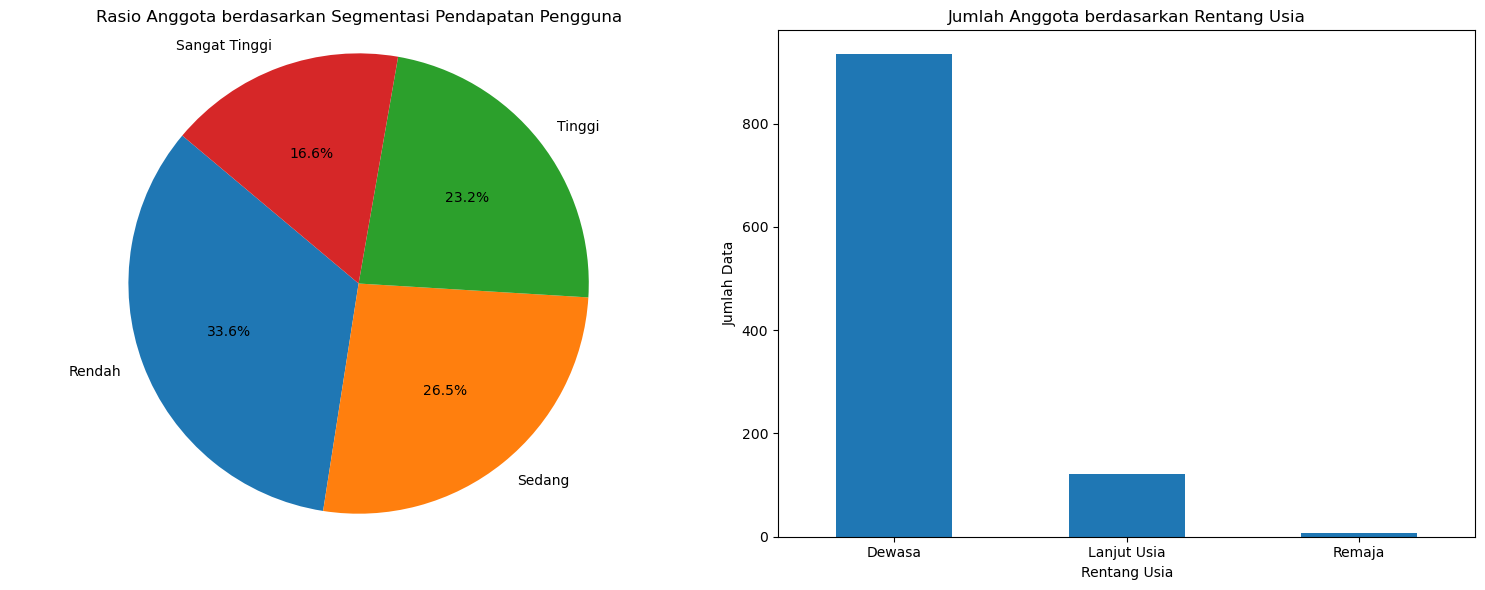

In [1166]:
# Membuat subplot dengan format 1 baris 2 kolom
plt.figure(figsize=(15, 6))

# Plotting pie chart untuk segmentasi pendapatan
plt.subplot(1, 2, 1)
countSegment = nowMemberDf['segmentasi_pendapatan'].value_counts()
labels = countSegment.index
sizes = countSegment.values
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Rasio Anggota berdasarkan Segmentasi Pendapatan Pengguna')

# Plotting bar chart untuk rentang usia
plt.subplot(1, 2, 2)
countAge = nowMemberDf['rentang_usia'].value_counts()
rot = 0
countAge.plot(kind='bar', title='Jumlah Kolom', rot=rot)

# Mengubah judul sumbu x dan y
plt.xlabel('Rentang Usia')  # Judul sumbu x
plt.ylabel('Jumlah Data')  # Judul sumbu y
plt.title('Jumlah Anggota berdasarkan Rentang Usia')  # Judul plot

# Menampilkan plot
plt.tight_layout()
plt.show()


Dari hasil visualisasi rasio keanggotaan berdasarkan segmentasi pendapatan di atas, dapat disimpulkan bahwa mayoritas pengguna yang sudah menjadi anggota adalah pengguna dengan rentang usia **Dewasa** dan dengan segmentasi pendapatan **Rendah**. Yang notabene rentang usia **Dewasa** sudah berpenghasilan.

Hal ini berhubungan dengan adanya keuntungan lebih ketika menjadi anggota, yaitu seperti mendapatkan diskon dan lain-lain.

### Pertanyaan 9



In [1167]:
# Membuat list kolom belanja
kolomBelanja = ['belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue']

# Membuat dictionary untuk menyimpan nilai mean dan std
nilai_statistik = {}

# Loop untuk setiap segmentasi pendapatan
for status in cleanedTraining['status_pernikahan'].unique():
    # Loop untuk setiap sub-segmentasi
    for child in cleanedTraining['memiliki_anak'].unique():
        # Membuat kunci untuk dictionary
        kunci = f"{status}-{child}"
        
        # Membuat kondisi untuk filtering data
        kondisi = (cleanedTraining['status_pernikahan'] == status) & (cleanedTraining['memiliki_anak'] == child)
        
        # Membuat dictionary untuk menyimpan nilai mean dan std dari setiap kolom belanja
        nilai_statistik[kunci] = {}
        for kolom in kolomBelanja:
            # Menghitung mean dan std
            mean = buyingDfTrain[kondisi][kolom].mean()
            std = buyingDfTrain[kondisi][kolom].std()
            # Menyimpan nilai mean dan std ke dalam dictionary
            nilai_statistik[kunci][f"mean_{kolom}"] = mean
            nilai_statistik[kunci][f"std_{kolom}"] = std

**1. Belanja Buah**

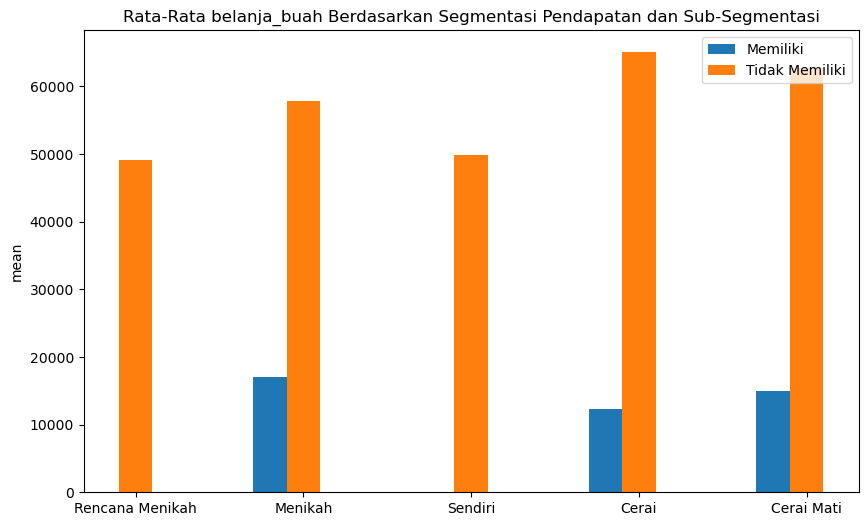

In [1168]:
# Membuat list status pernikahan dan memiliki anak
status_pernikahan = cleanedTraining['status_pernikahan'].unique().tolist()
memiliki_anak = ['Memiliki', 'Tidak Memiliki']

jenis_kolom_belanja = 'belanja_buah'
jenis_statistik = 'mean'

# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, status_pernikahan, memiliki_anak, jenis_statistik)

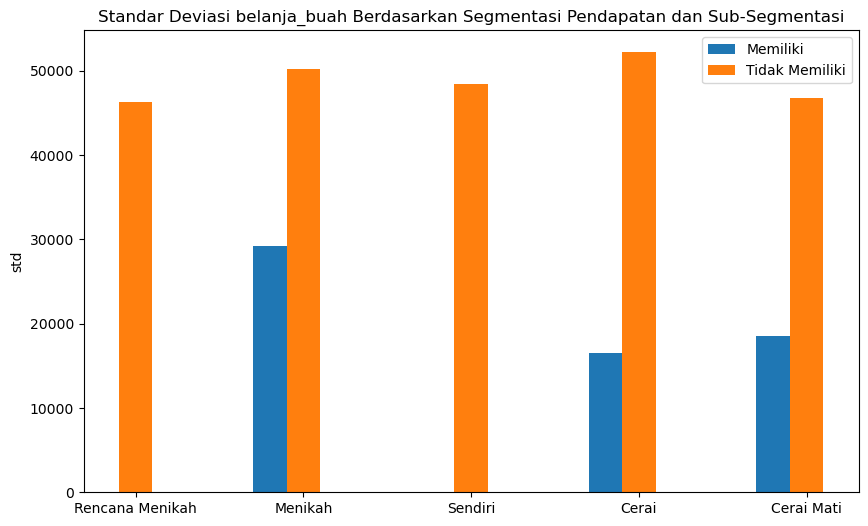

In [1169]:
jenis_kolom_belanja = 'belanja_buah'
jenis_statistik = 'std'

# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, status_pernikahan, memiliki_anak, jenis_statistik)

**2. Belanja Daging**

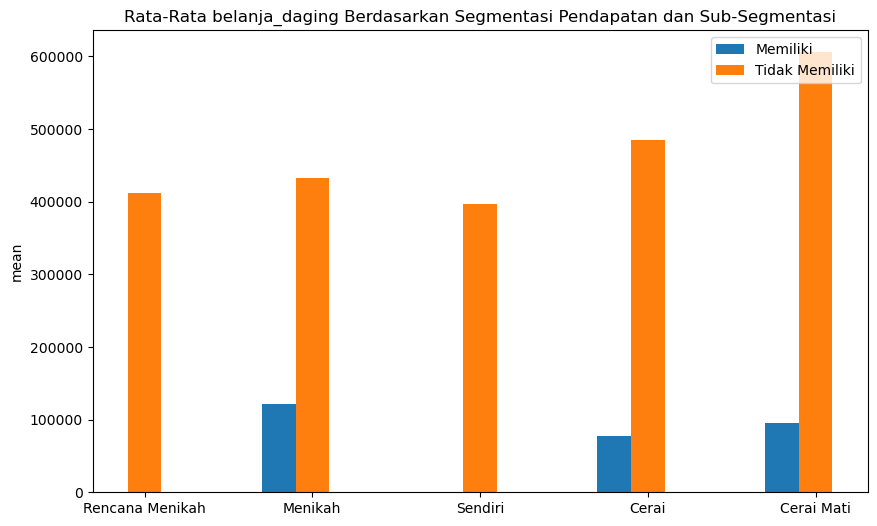

In [1170]:
jenis_kolom_belanja = 'belanja_daging'
jenis_statistik = 'mean'

# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, status_pernikahan, memiliki_anak, jenis_statistik)

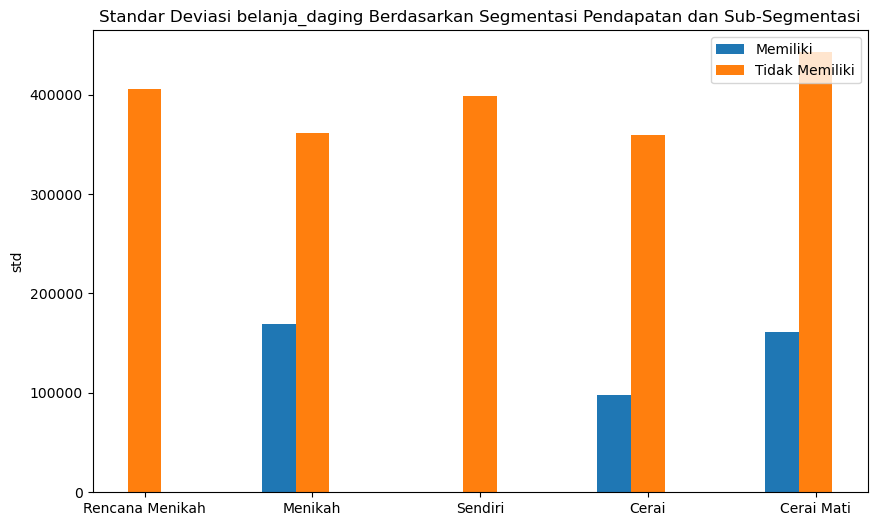

In [1171]:
jenis_kolom_belanja = 'belanja_daging'
jenis_statistik = 'std'

# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, status_pernikahan, memiliki_anak, jenis_statistik)

**3. Belanja Ikan**

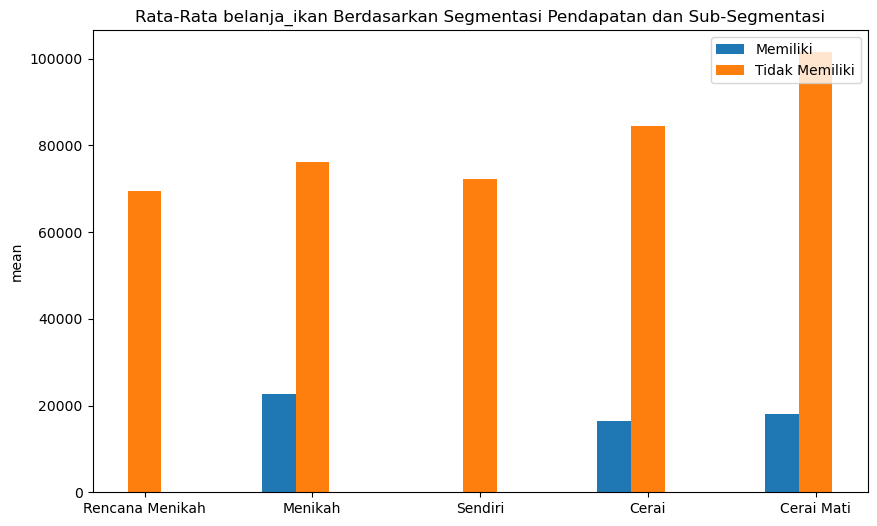

In [1172]:
jenis_kolom_belanja = 'belanja_ikan'
jenis_statistik = 'mean'

# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, status_pernikahan, memiliki_anak, jenis_statistik)

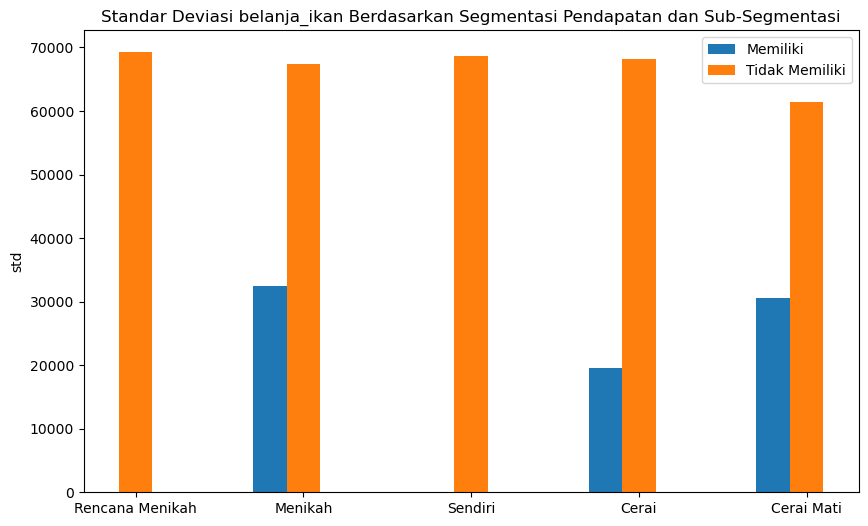

In [1173]:
jenis_kolom_belanja = 'belanja_ikan'
jenis_statistik = 'std'

# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, status_pernikahan, memiliki_anak, jenis_statistik)

**4. Belanja Kue**

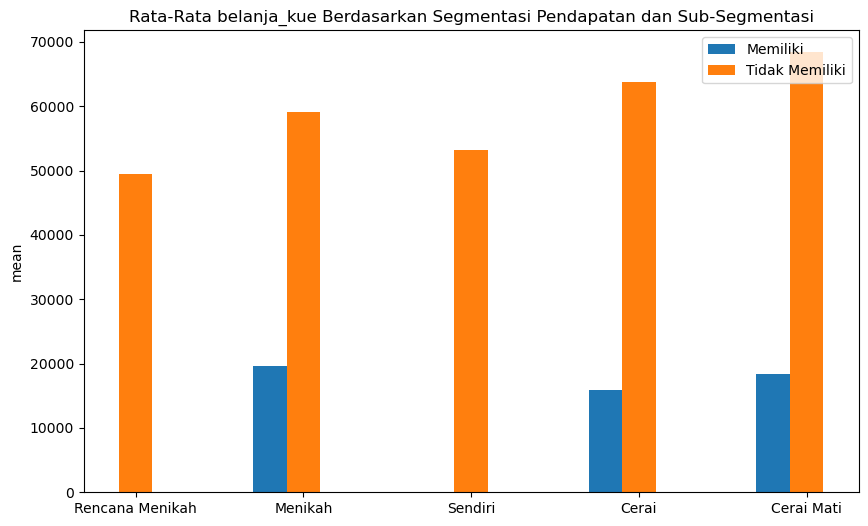

In [1174]:
jenis_kolom_belanja = 'belanja_kue'
jenis_statistik = 'mean'

# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, status_pernikahan, memiliki_anak, jenis_statistik)

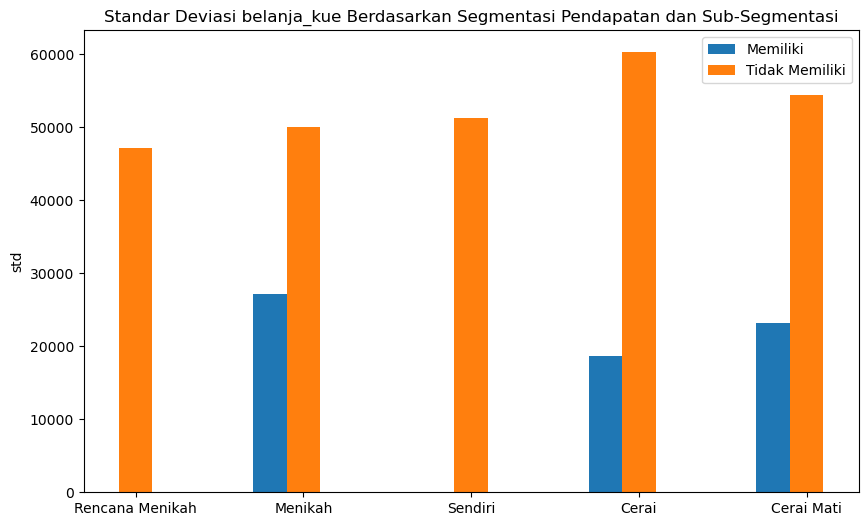

In [1175]:
jenis_kolom_belanja = 'belanja_kue'
jenis_statistik = 'std'

# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, status_pernikahan, memiliki_anak, jenis_statistik)

Dari hasil analisis di atas, terdapat potensi penjualan terhadap pembelian pelanggan yang **Tidak Memiliki Anak**. Dengan rincian sebagai berikut:

- Pembelian **Belanja Buah**, dominan kategori status pernikahan secara berurutan yaitu **Menikah** dan **Cerai**.
- Pembelian **Belanja Daging**, dominan kategori status pernikahan secara berurutan yaitu **Cerai Mati** dan **Rencana Menikah**.
- Pembelian **Belanja Ikan**, sedikit berbeda karena perbedaan nilai mean dan std yang cukup signifikan, maka dominan kategori status pernikahan secara berurutan yaitu **Rencana Menikah** dan **Sendiri**. Karena pertimbangan nilai std yang lebih seimbang.
- Pembelian **Belanja Kue**, dominan kategori status pernikahan secara berurutan yaitu **Sendiri** dan **Cerai**.

Selanjutnya dapat dilakukan promosi lebih pada kategori-kategori di atas, pada setiap kategori belanja yang ada.

## Feature Extraction

Sesi ini dilakukan analisis hubungan nilai statistik dan demografis pengguna dengan banyak promosi yang sudah dilakukan sebelumnya. Tujuan dari analisis ini adalah untuk memberikan *insight* agar promosi yang dilakukan selanjutnya dapat dilaksanakan secara maksimal. Pada sesi ini diperlukan proses-proses yang dilakukan yaitu **Ekstraksi Fitur** untuk memaksimalkan fitur-fitur yang digunakan ke dalam model. 


In [1176]:
cleanedTraining.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3798 entries, 0 to 3816
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   tahun_kelahiran          3798 non-null   int64   
 1   pendidikan               3798 non-null   object  
 2   status_pernikahan        3798 non-null   object  
 3   pendapatan               3798 non-null   float64 
 4   jumlah_anak_balita       3798 non-null   int32   
 5   jumlah_anak_remaja       3798 non-null   int32   
 6   terakhir_belanja         3798 non-null   int64   
 7   belanja_buah             3798 non-null   float64 
 8   belanja_daging           3798 non-null   float64 
 9   belanja_ikan             3798 non-null   float64 
 10  belanja_kue              3798 non-null   float64 
 11  pembelian_diskon         3798 non-null   float64 
 12  pembelian_web            3798 non-null   float64 
 13  pembelian_toko           3798 non-null   float64 
 14  keluhan      

Dari setiap kolom yang ditampilkan, dan hasil dari analisis dari pertanyaan-pertanyaan sebelumnya. Maka pada sesi ini akan menjelaskan menggunakan analisis statistik deskriptif untuk membuat strategi dalam memaksimalkan data, yang nantinya akan dilakukan proses prediksi.

Disini kami menggunakan beberapa variabel untuk melakukan iterasi dalam melakukan analisis, yaitu:

1. Segmentasi Pendapatan
2. Kepemilikan Anak
3. Rentang Usia
4. Keluhan
5. Tanggal Menjadi Anggota

Serta variabel target sebagai berikut:

1. Belanja (Buah, Daging, Ikan, dan Kue)
2. Pembelian Diskon
3. Platform Pembelian (Web dan Toko)

### Pendapatan dengan Belanja

In [1177]:
def stuffPromote(df):
    # Looping tiap baris data
    for index, row in df.iterrows():
        # Kondisi tiap kolom belanja
        if row['segmentasi_pendapatan'] == 'Sangat Tinggi' and row['sub_segmentasi'] == 'Bawah':
            # Belanja Buah
            df.at[index, 'promosi_buah'] = 5
            # Belanja Daging
            df.at[index, 'promosi_daging'] = 2
            # Belanja Ikan
            df.at[index, 'promosi_ikan'] = 5
            # Belanja Kue
            df.at[index, 'promosi_kue'] = 4
        elif row['segmentasi_pendapatan'] == 'Tinggi' and row['sub_segmentasi'] == 'Atas':
            # Belanja Buah
            df.at[index, 'promosi_buah'] = 4
            # Belanja Daging
            df.at[index, 'promosi_daging'] = 3
            # Belanja Ikan
            df.at[index, 'promosi_ikan'] = 3
            # Belanja Kue
            df.at[index, 'promosi_kue'] = 2
        elif row['segmentasi_pendapatan'] == 'Tinggi' and row['sub_segmentasi'] == 'Bawah':
            # Belanja Buah
            df.at[index, 'promosi_buah'] = 3
            # Belanja Daging
            df.at[index, 'promosi_daging'] = 1
            # Belanja Ikan
            df.at[index, 'promosi_ikan'] = 2
            # Belanja Kue
            df.at[index, 'promosi_kue'] = 0
        elif row['segmentasi_pendapatan'] == 'Sangat Tinggi' and row['sub_segmentasi'] == 'Atas':
            # Belanja Buah
            df.at[index, 'promosi_buah'] = 2
            # Belanja Daging
            df.at[index, 'promosi_ikan'] = 4
            # Belanja Ikan
            df.at[index, 'promosi_daging'] = 4
            # Belanja Kue
            df.at[index, 'promosi_kue'] = 5
        elif row['segmentasi_pendapatan'] == 'Sangat Tinggi' and row['sub_segmentasi'] == 'Menengah':
            # Belanja Buah
            df.at[index, 'promosi_buah'] = 1
            # Belanja Daging
            df.at[index, 'promosi_daging'] = 5
            # Belanja Ikan
            df.at[index, 'promosi_ikan'] = 1
            # Belanja Kue
            df.at[index, 'promosi_kue'] = 3
        elif row['segmentasi_pendapatan'] == 'Tinggi' and row['sub_segmentasi'] == 'Menengah':
            # Belanja Buah
            df.at[index, 'promosi_buah'] = 0
            # Belanja Daging
            df.at[index, 'promosi_daging'] = 0
            # Belanja Ikan
            df.at[index, 'promosi_ikan'] = 0
            # Belanja Kue
            df.at[index, 'promosi_kue'] = 1
        else:
            # Belanja Buah
            df.at[index, 'promosi_buah'] = 0
            # Belanja Daging
            df.at[index, 'promosi_daging'] = 0
            # Belanja Ikan
            df.at[index, 'promosi_ikan'] = 0
            # Belanja Kue
            df.at[index, 'promosi_kue'] = 0

In [1178]:
# Data Training
stuffPromote(cleanedTraining)
# Data Testing
stuffPromote(cleanedTesting)

### Keluhan

In [1179]:
def complaints(df):
    # Looping tiap baris data
    for index, row in df.iterrows():
        # Cek keluhan
        if row['keluhan'] == 1:
            if row['pembelian_toko'] > row['pembelian_web']:
                df.at[index, 'prior_platform_promosi'] = 0
            else:
                df.at[index, 'prior_platform_promosi'] = 1
        else:
            df.at[index, 'prior_platform_promosi'] = 1

In [1180]:
# Data Training
complaints(cleanedTraining)
# Data Testing
complaints(cleanedTesting)

### Kepemilikan Anak

In [1181]:
# List kolom promosi
kolomPromosi = ['promosi_buah', 'promosi_daging', 'promosi_ikan', 'promosi_kue']

def marriedAndChild(df):
    # Looping tiap baris data
    for index, row in df.iterrows():
        # Cek apakah memiliki anak
        if row['memiliki_anak'] == 'Tidak Memiliki':
            # Looping isi list kolom promosi
            for col in kolomPromosi:
                if row['status_pernikahan'] == 'Menikah' and col == 'promosi_buah':
                    df.at[index, col] += 1
                elif row['status_pernikahan'] == 'Cerai' and col == 'promosi_buah':
                    df.at[index, col] += 0.5
                elif row['status_pernikahan'] == 'Cerai Mati' and col == 'promosi_daging':
                    df.at[index, col] += 1
                elif row['status_pernikahan'] == 'Rencana Menikah' and col == 'promosi_daging':
                    df.at[index, col] += 0.5
                elif row['status_pernikahan'] == 'Rencana Menikah' and col == 'promosi_ikan':
                    df.at[index, col] += 1
                elif row['status_pernikahan'] == 'Sendiri' and col == 'promosi_ikan':
                    df.at[index, col] += 0.5
                if row['status_pernikahan'] == 'Sendiri' and col == 'promosi_ikan':
                    df.at[index, col] += 1
                elif row['status_pernikahan'] == 'Cerai' and col == 'promosi_ikan':
                    df.at[index, col] += 0.5
                else:
                    df.at[index, col] += 0

In [1182]:
# Data Training
marriedAndChild(cleanedTraining)
# Data Testing
marriedAndChild(cleanedTesting)

# Data Preparation

In [1183]:
# Data Training
cleanedTraining.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3798 entries, 0 to 3816
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   tahun_kelahiran          3798 non-null   int64   
 1   pendidikan               3798 non-null   object  
 2   status_pernikahan        3798 non-null   object  
 3   pendapatan               3798 non-null   float64 
 4   jumlah_anak_balita       3798 non-null   int32   
 5   jumlah_anak_remaja       3798 non-null   int32   
 6   terakhir_belanja         3798 non-null   int64   
 7   belanja_buah             3798 non-null   float64 
 8   belanja_daging           3798 non-null   float64 
 9   belanja_ikan             3798 non-null   float64 
 10  belanja_kue              3798 non-null   float64 
 11  pembelian_diskon         3798 non-null   float64 
 12  pembelian_web            3798 non-null   float64 
 13  pembelian_toko           3798 non-null   float64 
 14  keluhan      

In [1184]:
# Data Testing
cleanedTesting.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3815 entries, 0 to 3817
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   ID                       3815 non-null   int64   
 1   tahun_kelahiran          3815 non-null   int64   
 2   pendidikan               3815 non-null   object  
 3   status_pernikahan        3815 non-null   object  
 4   pendapatan               3815 non-null   float64 
 5   jumlah_anak_balita       3815 non-null   int32   
 6   jumlah_anak_remaja       3815 non-null   int32   
 7   terakhir_belanja         3815 non-null   float64 
 8   belanja_buah             3815 non-null   float64 
 9   belanja_daging           3815 non-null   float64 
 10  belanja_ikan             3815 non-null   float64 
 11  belanja_kue              3815 non-null   float64 
 12  pembelian_diskon         3815 non-null   float64 
 13  pembelian_web            3815 non-null   float64 
 14  pembelian_tok

## Transformasi Data

Pada sesi ini akan mengubah kolom kategorikal menjadi kolom numerikal yang merupakan sebuah kategori berdasarkan data. Kolom kategori terdiri dari kolom bertipe data **object** dan **category**.

In [1185]:
# Mengambil hanya kolom kategorikal
# Data Training
nonNumericTrain = cleanedTraining.select_dtypes(exclude=['number']).columns
print(nonNumericTrain)

# Data Testing
nonNumericTesting = cleanedTesting.select_dtypes(exclude=['number']).columns
print(nonNumericTesting)

Index(['pendidikan', 'status_pernikahan', 'tanggal_menjadi_anggota',
       'segmentasi_pendapatan', 'rentang_usia', 'memiliki_anak',
       'sub_segmentasi'],
      dtype='object')
Index(['pendidikan', 'status_pernikahan', 'tanggal_menjadi_anggota',
       'segmentasi_pendapatan', 'rentang_usia', 'memiliki_anak',
       'sub_segmentasi'],
      dtype='object')


### Kolom Pendidikan

In [1186]:
# Cek Nilai Unique
# Data Training
print(cleanedTraining['pendidikan'].unique())

# Data Testing
print(cleanedTesting['pendidikan'].unique())

['Sarjana' 'Magister' 'SMA' 'SMP' 'Doktor']
['Sarjana' 'Doktor' 'SMA' 'Magister' 'SMP']


In [1187]:
# Buat fungsi transformasi
def transformPendidikan(row):
    if row['pendidikan'] == "Sarjana" :
        return 0
    elif row['pendidikan'] == "Magister" :
        return 1
    elif row['pendidikan'] == "SMA" :
        return 2
    elif row['pendidikan'] == "SMP" :
        return 3
    elif row['pendidikan'] == "Doktor" :
        return 4

# Penerapan Fungsi
# Data Training
cleanedTraining['pendidikan'] = cleanedTraining.apply(transformPendidikan, axis=1).astype(int)

# Data Testing
cleanedTesting['pendidikan'] = cleanedTesting.apply(transformPendidikan, axis=1).astype(int)

In [1188]:
# Validasi hasil transformasi
# Data Training
print(cleanedTraining['pendidikan'].unique())

# Data Testing
print(cleanedTesting['pendidikan'].unique())

[0 1 2 3 4]
[0 4 2 1 3]


### Kolom Status Pernikahan

In [1189]:
# Cek Nilai Unique
# Data Training
print(cleanedTraining['status_pernikahan'].unique())

# Data Testing
print(cleanedTesting['status_pernikahan'].unique())

['Rencana Menikah' 'Menikah' 'Sendiri' 'Cerai' 'Cerai Mati']
['Menikah' 'Rencana Menikah' 'Sendiri' 'Cerai Mati' 'Cerai']


In [1190]:
# Buat Fungsi Transformasi
def transformPernikahan(row):
    if row['status_pernikahan'] == "Rencana Menikah" :
        return 0
    elif row['status_pernikahan'] == "Menikah" :
        return 1
    elif row['status_pernikahan'] == "Sendiri" :
        return 2
    elif row['status_pernikahan'] == "Cerai" :
        return 3
    elif row['status_pernikahan'] == "Cerai Mati" :
        return 4

# Penerapan Fungsi
# Data Training
cleanedTraining['status_pernikahan'] = cleanedTraining.apply(transformPernikahan, axis=1).astype(int)

# Data Testing
cleanedTesting['status_pernikahan'] = cleanedTesting.apply(transformPernikahan, axis=1).astype(int)

In [1191]:
# Validasi hasil transformasi
# Data Training
print(cleanedTraining['status_pernikahan'].unique())

# Data Testing
print(cleanedTesting['status_pernikahan'].unique())

[0 1 2 3 4]
[1 0 2 4 3]


### Kolom Keanggotaan

In [1192]:
# Buat fungsi transformasi
def transformKeanggotaan(row):
    return 1 if row['tanggal_menjadi_anggota'] != 'Unknown' else 0

# Penerapan Fungsi
# Data Training

cleanedTraining['tanggal_menjadi_anggota'] = cleanedTraining.apply(transformKeanggotaan, axis=1).astype(int)

# Data Testing
cleanedTesting['tanggal_menjadi_anggota'] = cleanedTesting.apply(transformKeanggotaan, axis=1).astype(int)

In [1193]:
# Validasi hasil transformasi
# Data Training
print(cleanedTraining['tanggal_menjadi_anggota'].unique())

# Data Testing
print(cleanedTesting['tanggal_menjadi_anggota'].unique())

[1 0]
[0 1]


### Kolom Segmentasi Pendapatan

In [1194]:
def transformSegementasi(row):
    if row['segmentasi_pendapatan'] == "Rendah" :
        return 0
    elif row['segmentasi_pendapatan'] == "Sedang" :
        return 1
    elif row['segmentasi_pendapatan'] == "Tinggi" :
        return 2
    elif row['segmentasi_pendapatan'] == "Sangat Tinggi" :
        return 3

# Penerapan Fungsi
# Data Training
cleanedTraining['segmentasi_pendapatan'] = cleanedTraining.apply(transformSegementasi, axis=1).astype(int)

# Data Testing
cleanedTesting['segmentasi_pendapatan'] = cleanedTesting.apply(transformSegementasi, axis=1).astype(int)

In [1195]:
# Validasi hasil transformasi
# Data Training
print(cleanedTraining['segmentasi_pendapatan'].unique())

# Data Testing
print(cleanedTesting['segmentasi_pendapatan'].unique())

[1 2 3 0]
[2 3 0 1]


### Kolom Rentang Usia

In [1196]:
def transformUsia(row):
    if row['rentang_usia'] == "Remaja" :
        return 0
    elif row['rentang_usia'] == "Dewasa" :
        return 1
    elif row['rentang_usia'] == "Lanjut Usia" :
        return 2

# Penerapan Fungsi
# Data Training
cleanedTraining['rentang_usia'] = cleanedTraining.apply(transformUsia, axis=1).astype(int)

# Data Testing
cleanedTesting['rentang_usia'] = cleanedTesting.apply(transformUsia, axis=1).astype(int)

In [1197]:
# Validasi hasil transformasi
# Data Training
print(cleanedTraining['rentang_usia'].unique())

# Data Testing
print(cleanedTesting['rentang_usia'].unique())

[1 2 0]
[1 2 0]


### Kolom Memiliki Anak

In [1198]:
def transformAnak(row):
    return 1 if row['memiliki_anak'] != 'Memiliki' else 0

# Penerapan Fungsi
# Data Training
cleanedTraining['memiliki_anak'] = cleanedTraining.apply(transformAnak, axis=1).astype(int)

# Data Testing
cleanedTesting['memiliki_anak'] = cleanedTesting.apply(transformAnak, axis=1).astype(int)

In [1199]:
# Validasi hasil transformasi
# Data Training
print(cleanedTraining['memiliki_anak'].unique())

# Data Testing
print(cleanedTesting['memiliki_anak'].unique())

[1 0]
[1 0]


### Kolom Sub Segmentasi

In [1200]:
def transformSubsegmen(row):
    if row['sub_segmentasi'] == "Bawah" :
        return 0
    elif row['sub_segmentasi'] == "Menengah" :
        return 1
    elif row['sub_segmentasi'] == "Atas" :
        return 2

# Penerapan Fungsi
# Data Training
cleanedTraining['sub_segmentasi'] = cleanedTraining.apply(transformSubsegmen, axis=1).astype(int)

# Data Testing
cleanedTesting['sub_segmentasi'] = cleanedTesting.apply(transformSubsegmen, axis=1).astype(int)

In [1201]:
# Validasi hasil transformasi
# Data Training
print(cleanedTraining['sub_segmentasi'].unique())

# Data Testing
print(cleanedTesting['sub_segmentasi'].unique())

[2 0 1]
[0 1 2]


## Persiapan Data Testing

Pada sesi ini dilakukan pemisahan kolom ID pada **Data Testing** dan pelabelan penanda untuk integrasi hasil prediksi model nantinya.

In [1202]:
# Buat label data training/testing
cleanedTraining['is_train'] = True
cleanedTesting['is_train'] = False

In [1203]:
# Memisahkan kolom label penanda dan ID ke dalam variabel
penanda1 = cleanedTraining['is_train']
penanda2 = cleanedTesting['is_train']
penanda3 = cleanedTesting['ID']

# Hapus kolom label penanda dan ID
cleanedTraining.drop(columns=['is_train'], inplace=True)
cleanedTesting.drop(columns=['is_train'], inplace=True)
cleanedTesting.drop(columns=['ID'], inplace=True)

## Reduksi Dimensi

Pada sesi ini dilakukan pengurangan lebar dimensi data yang akan dilakukan training dan testing dengan guna agar model dapat memproses dengan lebih cepat.


### Hapus Kolom Tidak Digunakan

In [1204]:
def delColumns(df):
    # Definisikan kolom yang akan dihapus
    unusedColumns = ['tahun_kelahiran', 'jumlah_anak_balita', 'jumlah_anak_remaja']
    
    df.drop(unusedColumns, axis=1, inplace=True)

# Data Training
delColumns(cleanedTraining)
# Data Testing
delColumns(cleanedTesting)

### Principal Component Analysis (PCA)

Pada sesi ini akan dilakukan analisis kolom-kolom yang notabene memiliki ciri sama, baik dari segi nilai maupun maksudnya. Kolom-kolom ini akan dicari yang paling berkorelasi dengan keseluruhan data yang ada, dan akan di *drop* kolom lain yang tidak digunakan.

Untuk kolom yang digunakan yaitu kolom-kolom belanja dan promosi seperti **Belanja Buah**, **Belanja Daging**, **Belanja Ikan**, dan **Belanja Kue**. Lalu kolom **Promosi Buah**, **Promosi Daging**, **Promosi Ikan**, dan **Promosi Kue**.

**Inisiasi Fungsi PCA**

In [1205]:
# Fungsi Tes PCA
def testPCA(df, cols):
    # inisiasi library PCA
    pca = PCA(n_components=4, random_state=123)
    # Penyesuaian PCA dengan kolom yang dieksekusi
    pca.fit(df[cols])
    # Ambil nilai varians
    variansVal = pca.transform(df[cols])
    
    return variansVal, pca

PCA menggunakan nilai *n-components* 4 sebab terdapat 4 kolom (PC) yang akan dilakukan tes PCA, dengan *random state* 123 agar distribusi yang dilakukan proses PCA selalu konsisten sama.

In [1206]:
# Fungsi Transformasi PCA
def transformPCA (df, cols, dataLabel):
    # inisiasi library PCA
    pca = PCA(n_components=1, random_state=123)
    # Penyesuaian PCA dengan kolom yang dieksekusi
    pca.fit(df[cols])
    # Definisi kolom baru
    newCol = 'prior_promosi' if dataLabel == 1 else 'belanja'
    # Transformasi keempat kolom menjadi satu kolom belanja
    df[newCol] = pca.transform(df.loc[:, cols]).flatten()
    # Menghapus kolom-kolom belanja sebelumnya
    df.drop(cols, axis=1, inplace=True)

PCA menggunakan nilai *n-components* 1 sebab terdapat 1 kolom (PC) yang akan dijadikan nilai hasil transformasi, dengan *random state* 123 agar distribusi yang dilakukan proses PCA selalu konsisten sama.

**Kolom Belanja**

In [1207]:
# Data Training
variansValue, pca = testPCA(cleanedTraining, kolomBelanja)
print('Nilai varians tiap kolom belanja di Data Training:', pca.explained_variance_ratio_.round(3))

# Data Training
variansValue, pca = testPCA(cleanedTesting, kolomBelanja)
print('Nilai varians tiap kolom belanja di Data Training:', pca.explained_variance_ratio_.round(3))

Nilai varians tiap kolom belanja di Data Training: [0.964 0.022 0.008 0.006]
Nilai varians tiap kolom belanja di Data Training: [0.966 0.021 0.007 0.005]


Dari hasil eksekusi PCA di atas, diperoleh nilai varians terbesar sebagai PC yang berpengaruh berdasarkan urutan yaitu PC pertama sebesar kurang lebih **96%**. Selanjutnya yaitu melakukan transformasi pada setiap kolom belanja menjadi satu kolom saja yaitu kolom **Belanja**.

In [1208]:
# Data Training
transformPCA(cleanedTraining, kolomBelanja, 0)
# Data Testing
transformPCA(cleanedTesting, kolomBelanja, 0)

**Kolom Promosi**

In [1209]:
# Data Training
variansValue, pca = testPCA(cleanedTraining, kolomPromosi)
print('Nilai varians tiap kolom promosi di Data Training:', pca.explained_variance_ratio_.round(3))

# Data Training
variansValue, pca = testPCA(cleanedTesting, kolomPromosi)
print('Nilai varians tiap kolom promosi di Data Training:', pca.explained_variance_ratio_.round(3))

Nilai varians tiap kolom promosi di Data Training: [0.789 0.131 0.058 0.022]
Nilai varians tiap kolom promosi di Data Training: [0.804 0.124 0.051 0.022]


Dari hasil eksekusi PCA di atas, diperoleh nilai varians terbesar sebagai PC yang berpengaruh berdasarkan urutan yaitu **PC Pertama** sebesar kurang lebih **79%** di Data Training dan **80%** di Data Testing. Selanjutnya yaitu melakukan transformasi pada setiap kolom belanja menjadi satu kolom saja yaitu kolom **Prioritas Promosi**.

In [1210]:
# Data Training
transformPCA(cleanedTraining, kolomPromosi, 1)
# Data Testing
transformPCA(cleanedTesting, kolomPromosi, 1)

In [1211]:
# Cek info data training
cleanedTraining.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3798 entries, 0 to 3816
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pendidikan               3798 non-null   int32  
 1   status_pernikahan        3798 non-null   int32  
 2   pendapatan               3798 non-null   float64
 3   terakhir_belanja         3798 non-null   int64  
 4   pembelian_diskon         3798 non-null   float64
 5   pembelian_web            3798 non-null   float64
 6   pembelian_toko           3798 non-null   float64
 7   keluhan                  3798 non-null   float64
 8   tanggal_menjadi_anggota  3798 non-null   int32  
 9   jumlah_promosi           3798 non-null   int64  
 10  segmentasi_pendapatan    3798 non-null   int32  
 11  usia                     3798 non-null   int64  
 12  rentang_usia             3798 non-null   int32  
 13  memiliki_anak            3798 non-null   int32  
 14  sub_segmentasi           3798

In [1212]:
# Cek info data testing
cleanedTesting.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3815 entries, 0 to 3817
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pendidikan               3815 non-null   int32  
 1   status_pernikahan        3815 non-null   int32  
 2   pendapatan               3815 non-null   float64
 3   terakhir_belanja         3815 non-null   float64
 4   pembelian_diskon         3815 non-null   float64
 5   pembelian_web            3815 non-null   float64
 6   pembelian_toko           3815 non-null   float64
 7   keluhan                  3815 non-null   float64
 8   tanggal_menjadi_anggota  3815 non-null   int32  
 9   segmentasi_pendapatan    3815 non-null   int32  
 10  usia                     3815 non-null   int64  
 11  rentang_usia             3815 non-null   int32  
 12  memiliki_anak            3815 non-null   int32  
 13  sub_segmentasi           3815 non-null   int32  
 14  prior_platform_promosi   3815

In [1213]:
cleanedTesting.head()

,pendidikan,status_pernikahan,pendapatan,terakhir_belanja,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota,segmentasi_pendapatan,usia,rentang_usia,memiliki_anak,sub_segmentasi,prior_platform_promosi,belanja,prior_promosi
0,0,1,120660151.0,63.0,4.0,6.0,10.0,0.0,0,2,67,1,1,0,1.0,1.506307e+05,0.180899
1,4,1,163551821.0,58.0,2.0,5.0,10.0,0.0,0,3,56,1,1,1,1.0,-6.041071e+04,2.133047
2,2,1,29857000.0,34.0,2.0,0.0,5.0,0.0,1,0,56,1,1,0,1.0,-3.943609e+05,-2.771374
3,4,1,117949098.0,82.0,3.0,5.0,7.0,0.0,0,2,53,1,1,0,1.0,-2.964017e+05,0.180899
4,0,0,164761134.0,28.0,0.0,1.0,8.0,0.0,0,3,50,1,1,1,1.0,1.020146e+06,2.484891


## Standarisasi 

Pada proses ini akan dilakukan standarisasi pada kolom **Pendapatan** agar rentang nilai tidak terlalu jauh dengan kolom-kolom lainnya, dengan tujuan agar model dapat memproses data lebih cepat.

**Data Training**

In [1214]:
# # Inisialisasi objek StandardScaler
# scaler = StandardScaler()

# # Reshape kolom pendapatan menjadi array 2 dimensi (untuk kebutuhan fit_transform)
# pendapatan = cleanedTraining.values.reshape(-1, 1)

# # Standarisasi data pendapatan
# pendapatanStandar = scaler.fit_transform(pendapatan)

# # Konversi hasil standarisasi kembali ke dalam bentuk Series pandas
# cleanedTraining['pendapatan'] = pendapatanStandar.flatten()

In [1215]:
cleanedTraining.pendapatan.sample(5)

819      29618765.0
1240     49857315.0
3661    132584000.0
2767    162395000.0
1749    129361661.0
Name: pendapatan, dtype: float64

**Data Testing**

In [1216]:
# # Inisialisasi objek StandardScaler
# scaler = StandardScaler()

# # Reshape kolom pendapatan menjadi array 2 dimensi (untuk kebutuhan fit_transform)
# pendapatan = cleanedTesting.values.reshape(-1, 1)

# # Standarisasi data pendapatan
# pendapatanStandar = scaler.fit_transform(pendapatan)

# # Konversi hasil standarisasi kembali ke dalam bentuk Series pandas
# cleanedTesting['pendapatan'] = pendapatanStandar.flatten()

In [1217]:
cleanedTesting.pendapatan.sample(5)

523     1.153137e+08
3400    1.172391e+08
449     1.174240e+08
2220    1.236409e+08
3338    1.100380e+08
Name: pendapatan, dtype: float64

## Rekonstruksi Dataset

Tujuan dari proses ini adalah untuk merapikan dataset agar lebih mudah dibaca, dan memperjelas maksud dari nama-nama kolom dengan tujuan dibentuknya kolom itu.

In [1218]:
# Ubah nama kolom keanggotaan
# Data Training
cleanedTraining = cleanedTraining.rename(columns={'tanggal_menjadi_anggota': 'anggota'})
# Data Testing
cleanedTesting = cleanedTesting.rename(columns={'tanggal_menjadi_anggota': 'anggota'})

In [1219]:
# Data Training
newOrderDataTrain = ['usia', 'rentang_usia','pendidikan', 'status_pernikahan', 'memiliki_anak',
                'pendapatan', 'segmentasi_pendapatan', 'sub_segmentasi', 'belanja',
                'terakhir_belanja','anggota', 'pembelian_diskon', 'pembelian_web', 'pembelian_toko',
                'keluhan', 'prior_promosi', 'prior_platform_promosi', 'jumlah_promosi']

cleanedTraining = cleanedTraining.reindex(columns=newOrderDataTrain)

In [1220]:
cleanedTraining.head()

,usia,rentang_usia,pendidikan,status_pernikahan,memiliki_anak,pendapatan,segmentasi_pendapatan,sub_segmentasi,belanja,terakhir_belanja,anggota,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,prior_promosi,prior_platform_promosi,jumlah_promosi
0,45,1,0,0,1,1.138377e+08,1,2,-123210.356712,47,1,2.0,2.0,5.0,0.0,-2.532409,1.0,2
1,74,2,0,0,1,8.406300e+07,1,0,-336977.676221,70,1,6.0,6.0,4.0,0.0,-2.532409,1.0,0
2,58,1,0,1,1,1.275326e+08,2,1,-98381.826563,45,0,1.0,1.0,7.0,0.0,-2.323182,1.0,1
3,63,1,1,0,1,1.655796e+08,3,2,282862.770790,90,0,0.0,7.0,8.0,0.0,5.047759,1.0,4
4,54,1,0,0,1,1.177032e+08,2,0,-70037.376924,78,0,6.0,6.0,5.0,0.0,0.404041,1.0,4


In [1221]:
cleanedTesting.columns

Index(['pendidikan', 'status_pernikahan', 'pendapatan', 'terakhir_belanja',
       'pembelian_diskon', 'pembelian_web', 'pembelian_toko', 'keluhan',
       'anggota', 'segmentasi_pendapatan', 'usia', 'rentang_usia',
       'memiliki_anak', 'sub_segmentasi', 'prior_platform_promosi', 'belanja',
       'prior_promosi'],
      dtype='object')

In [1222]:
# Data Testing
newOrderDataTest = ['usia', 'rentang_usia','pendidikan', 'status_pernikahan', 'memiliki_anak',
                'pendapatan', 'segmentasi_pendapatan', 'sub_segmentasi', 'belanja',
                'terakhir_belanja', 'anggota', 'pembelian_diskon', 'pembelian_web', 'pembelian_toko',
                'keluhan', 'prior_promosi', 'prior_platform_promosi']

cleanedTesting = cleanedTesting.reindex(columns=newOrderDataTest)

In [1223]:
cleanedTesting.head()

,usia,rentang_usia,pendidikan,status_pernikahan,memiliki_anak,pendapatan,segmentasi_pendapatan,sub_segmentasi,belanja,terakhir_belanja,anggota,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,prior_promosi,prior_platform_promosi
0,67,1,0,1,1,120660151.0,2,0,1.506307e+05,63.0,0,4.0,6.0,10.0,0.0,0.180899,1.0
1,56,1,4,1,1,163551821.0,3,1,-6.041071e+04,58.0,0,2.0,5.0,10.0,0.0,2.133047,1.0
2,56,1,2,1,1,29857000.0,0,0,-3.943609e+05,34.0,1,2.0,0.0,5.0,0.0,-2.771374,1.0
3,53,1,4,1,1,117949098.0,2,0,-2.964017e+05,82.0,0,3.0,5.0,7.0,0.0,0.180899,1.0
4,50,1,0,0,1,164761134.0,3,1,1.020146e+06,28.0,0,0.0,1.0,8.0,0.0,2.484891,1.0


In [1224]:
cleanedTraining.sample()

,usia,rentang_usia,pendidikan,status_pernikahan,memiliki_anak,pendapatan,segmentasi_pendapatan,sub_segmentasi,belanja,terakhir_belanja,anggota,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,prior_promosi,prior_platform_promosi,jumlah_promosi
3479,60,1,1,0,1,1.153707e+08,2,0,-55753.64682,92,0,0.0,7.0,8.0,0.0,0.404041,1.0,4


# Model Development

In [1225]:
cleanedTesting['jumlah_promosi'] = pd.Series(dtype=int)

In [1226]:
print(cleanedTraining.columns)

Index(['usia', 'rentang_usia', 'pendidikan', 'status_pernikahan',
       'memiliki_anak', 'pendapatan', 'segmentasi_pendapatan',
       'sub_segmentasi', 'belanja', 'terakhir_belanja', 'anggota',
       'pembelian_diskon', 'pembelian_web', 'pembelian_toko', 'keluhan',
       'prior_promosi', 'prior_platform_promosi', 'jumlah_promosi'],
      dtype='object')


In [1227]:
features = cleanedTraining[['usia', 'rentang_usia','status_pernikahan', 'memiliki_anak',
                'pendapatan', 'segmentasi_pendapatan', 'sub_segmentasi', 'belanja',
                'terakhir_belanja','anggota', 'pembelian_diskon', 'pembelian_web', 'pembelian_toko',
                'keluhan', 'prior_promosi', 'prior_platform_promosi']]

labels = cleanedTraining['jumlah_promosi']

In [1228]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=123)

print('X_train size :',X_train.shape)
print('y_train size :',y_train.shape)
print('X_test size  :',X_test.shape)
print('y_test size  :',y_test.shape)

X_train size : (3038, 16)
y_train size : (3038,)
X_test size  : (760, 16)
y_test size  : (760,)


In [1229]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=200, max_depth=57, max_features=12)
rf_model.fit(X_train, y_train)

sfm = SelectFromModel(rf_model, threshold=0.05)  # Atur threshold sesuai kebutuhan
sfm.fit(X_train_scaled, y_train)
# Transformasi data train dan test berdasarkan fitur yang terpilih
X_train_selected = sfm.transform(X_train_scaled)
X_test_selected = sfm.transform(X_test_scaled)
# Buat model RandomForestClassifier baru dengan fitur yang terpilih
rf_model_selected = RandomForestClassifier(n_estimators=120, max_depth=57, max_features=10)
rf_model_selected.fit(X_train_selected, y_train)
# Prediksi
y_pred_selected = rf_model_selected.predict(X_test_selected)
# Evaluasi akurasi
accuracy_selected = accuracy_score(y_test, y_pred_selected)
print(f'Accuracy after feature selection: {accuracy_selected}')


Accuracy after feature selection: 0.7421052631578947


In [1230]:
print(classification_report(y_test, y_pred_selected))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69       207
           1       0.59      0.47      0.52        86
           2       0.79      0.66      0.72        86
           3       0.82      0.81      0.82        85
           4       0.84      0.90      0.87       103
           5       0.76      0.89      0.82       118
           6       0.79      0.71      0.75        75

    accuracy                           0.74       760
   macro avg       0.75      0.74      0.74       760
weighted avg       0.74      0.74      0.74       760



In [1231]:
# X_train = cleanedTraining.drop(columns=['jumlah_promosi'])
# y_train = cleanedTraining['jumlah_promosi']
# X_test = cleanedTesting.drop(columns=['jumlah_promosi'])

# # Encode categorical data
# label_encoder = LabelEncoder()
# X_train_encoded = X_train.copy()
# X_test_encoded = X_test.copy()
# categorical_cols = ['pendidikan', 'status_pernikahan', 'keluhan', 'tanggal_menjadi_anggota', 'segmentasi_pendapatan', 'rentang_usia', 'memiliki_anak', 'sub_segmentasi', 'promosi_buah', 'promosi_daging', 'promosi_ikan', 'promosi_kue', 'prior_platform_promosi']
# for col in categorical_cols:
#     X_train_encoded[col] = label_encoder.fit_transform(X_train[col])
#     X_test_encoded[col] = label_encoder.transform(X_test[col])

# # normalisasi datanya
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_encoded)
# X_test_scaled = scaler.transform(X_test_encoded)

# #nilai asli
# y_true = y_train.copy()

# # Train model
# model = RandomForestClassifier()
# model.fit(X_train_scaled, y_train)

# # Prediksi ke data testing
# y_pred = model.predict(X_test_scaled)

In [1232]:
# y_pred

In [1233]:
# from sklearn.model_selection import cross_val_score

# # Hitung skor validasi silang (cross-validation score)
# scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')  # Ganti 'accuracy' dengan metrik evaluasi yang sesuai

# # Tampilkan skor validasi silang
# print(f'Cross-Validation Scores: {scores}')
# print(f'Average Cross-Validation Score: {scores.mean()}')

In [1234]:
# hasil_prediksi = pd.DataFrame({'ID': penanda3, 'jumlah_promosi': y_pred})

# # Tampilkan hasil prediksi
# print(hasil_prediksi)

In [1235]:
# # Simpan DataFrame hasil_prediksi ke dalam file CSV
# hasil_prediksi.to_csv('test_labels.csv', index=False)

In [1236]:
# gabungan = pd.concat([cleanedTesting, cleanedTraining], ignore_index=True)

In [1237]:
# gabungan.sample()

In [1238]:
# penanda = gabungan['is_train']
# gabungan.drop(columns=['is_train'], inplace=True)

In [1239]:
# gabungan.isnull().sum()

In [1240]:
# StandardScaler = StandardScaler()

# dataNormalisasi = StandardScaler.fit_transform(gabungan)
# dataNormalisasi

In [1241]:
# z_scores = np.abs(dataNormalisasi - np.mean(dataNormalisasi, axis=0)) / np.std(dataNormalisasi, axis=0)
# threshold = 23  

# # Dapatkan indeks baris yang mengandung outlier
# outlier_indices = np.where(z_scores > threshold)

# # Hapus baris yang mengandung outlier dari dataNormalisasi
# gabungan = np.delete(dataNormalisasi, outlier_indices[0], axis=0)
# print(gabungan)